# Homework 3 CSCI 4364/6364 Machine Learning

## **A Tour of Multivariate Classification**

**Due Date: 10/17/2023, 23:59 ET**

---

**Purpose:**
This homework will provide you with hands-on experience with some of the multivariate classification algorithms we discussed in class and expose you to one of the most cited datasets, MNIST.

You should get a broad appreciation for the various approaches to classification that will help you evaluate which approach is best for your real world research or industry application.

The [MNIST](http://yann.lecun.com/exdb/mnist/) database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. MNIST is a good dataset for this assignment, since it has 10 classes (0 - 9) with a large number of features.


---
**Submission Instructions:**
This assignment will be done entirely in this Colaboratory notebook, and you will submit your notebook via GWU blackboard. Please embed your code in code blocks and add in comments into the text blocks.

> **Important:** Please save and submit your homework assignment notebook with outputs. You can do this by selecting `Edit` >> `Notebook settings` and making sure the option `Omit code cell output when saving this notebook` is **NOT** selected.

**Grading on the notebook:**
This notebook is worth up to 5% (with up to 3% additional extra credit) of the semester grade, where 3% is completion and full functionality, and 2% is based on comments and descriptions, and well-written and commented Python code, based on the coding standards. The notebook should be fully explained and work in its entirety when you submit it.

**Coding Standards:**
Throughout this course, we will use [Google’s Python Style Guide](https://google.github.io/styleguide/pyguide.html) as the coding standard for homework and project submission. A big part of machine learning in industry is applying good programming practices.


**Name:** [please add your name here]

**GW ID:** [your GWU student ID]

In [1]:
#@title Imports
## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ##
# Always include all imports at the first executable cell.
## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ##
from sklearn.datasets import fetch_openml
from keras.utils import to_categorical
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod # Abstract Base Classes for Python
import matplotlib.image as mpimg
import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from typing import Dict, Optional, List, Tuple, Union
import tensorflow as tf
from keras.callbacks import EarlyStopping
from gc import callbacks

First, download the MNIST data using the code provided below.

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Here are the first 9 digits of the MNIST data with label.


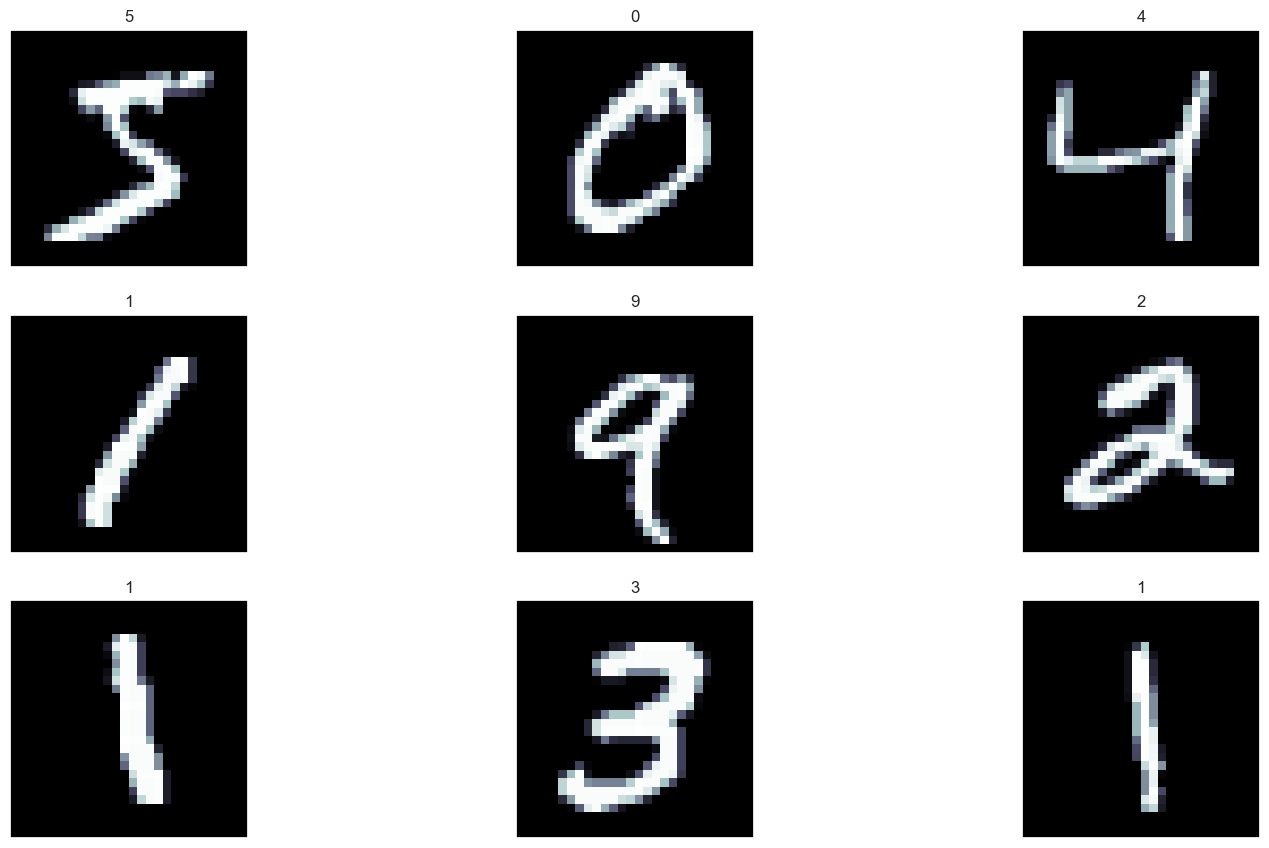

In [2]:
#@title Download MNIST, split, and plot example
def plot_example(x_raw, y_raw):
  fig, axes = plt.subplots(3, 3)
  i = 0
  for i in range(3):
    for j in range(3):
      imgplot = axes[i,j].imshow(x_raw[i*3 + j].reshape((28,28)), cmap = 'bone')
      axes[i,j].set_title(y_raw[i*3 + j])
      axes[i,j].get_yaxis().set_visible(False)
      axes[i,j].get_xaxis().set_visible(False)
  fig.set_size_inches(18.5, 10.5, forward=True)


x_raw, y_raw = fetch_openml('mnist_784', version=1, return_X_y=True)
x = (x_raw/255).astype('float32').to_numpy()

# Split the data set into train, validation, and test sets.
x_trainval, x_test, y_trainval, y_test = train_test_split(x, y_raw, test_size=0.10, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval, test_size=0.10, random_state=42)
print('Here are the first 9 digits of the MNIST data with label.')
plot_example(x, y_raw)

In [3]:
x_train.shape, x_val.shape, x_test.shape

((56700, 784), (6300, 784), (7000, 784))

As in the past assignments, we'll define our base learning algorithm class, and create multiple implementations. Here, in the fit (or train) method, along with x_train and y_train, we'll include x_val, and y_val, as validation sets. Not all implementations will use them.

In [4]:
#@title Define a base class class for Learning Algorithm

class BaseLearningAlgorithm(ABC):
  """Base class for a Supervised Learning Algorithm."""

  @abstractmethod
  def fit(self, x_train:np.array, y_train: np.array
          , x_val:np.array
          , y_val:np.array) -> None:
    """Trains a model from labels y and examples X.
    We include validation set for optional hyperparameter tuning. Not
    all of the algorithims we use will
    """

  @abstractmethod
  def predict(self, x_test: np.array) -> np.array:
    """Predicts on an unlabeled sample, X."""

  @property
  @abstractmethod
  def name(self) -> str:
    """Returns the name of the algorithm."""

Next, we want to establish a common approach to evaluating our implementations of `BaseLearningAlgorithm`.

A **Confusion Matrix** is a data table that helps visualize the performance of a multi-class classifier. The rows represent the true class assignmants from the test set labels, and the columns represent the predicted classes generated by the classifier. A perfect classifier will only populate the diagonal with counts and all off-diagonal elements of the matrix will be zero. Off-diagonal counts indiate that the model confuses the class in row $i$ with the class in column $j$. For example, in MNIST, the number $9$ might be confused $4$, and the associated cell at $i, j$ will be greater than $0$.

Besides precision and accuracy, the **F1-Score** is often used.  Review this [Wikipedia article](https://en.wikipedia.org/wiki/F-score) on F-Score.

##  [x] Question 1.
The Wikipedia article indicates that one weakness of the F-Score is that it assigns equal importance to precision and recall. Describe two scenarios where (a) precision may be more important to recall, and (b) where recall may be more important than precision.

It should always be kept in mind that all ofthe metrics used in Machine Learning are simply statistical metrics, ie. mathematical functions. The interpretation and specific usage will inevitably depend on the application. Assigning weights, adding penalties, and other techniques are often used to vary the metrics as necessary. Let's first recall (totally pun intended) the definitions of precision and recall.

$$ \text{Precision} = \frac{TP}{TP + FP} $$

$$ \text{Recall} = \frac{TP}{TP + FN} $$

where:
- TP = True Positive
- FP = False Positive

**a) Email spam detection**

In this case, we'd want the spam detector to be highly precise. A false positive would mean that a legitimate email was marked as spam, and the user would never see it leading to potential loss of crucial information. On the other hand, a false negative would mean that a spam email was not marked as spam, and the user would see it. This is not as bad as a false positive, since the users can, most of the time, identify and delete unwanted emails. Thus, fewer false positives are more important meaning that high precision is preferred.

**b) Medical diagnosis of a serious disease**

Here, the underlying principle is that it is "better to be safe than sorry". Basically we strive for the ability to identify as many true positive cases as possible even at the expense of some false positives. Missing a single case (low recall) can have severe consequences for the patient. A false positive can easily be re-examined by medical professionals with more tests to confirm the diagnosis, but a false negative could delay treatment for a patient who actually has the disease.

In other words, we want to minimize the number of false negatives as much as possible. Thus, high recall is preferred.

In [5]:
#@title Define a basic train and evaluation pipeline

def train_eval(learning_algo: BaseLearningAlgorithm, x_train, y_train,x_val, y_val, x_test, y_test,
               print_report: bool = True):
  """Trains and evaluates the generic model."""
  learning_algo.fit(x_train, y_train, x_val, y_val)
  y_pred = learning_algo.predict(x_test)
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred, average='macro')

  if print_report:
    print(classification_report(y_test, y_pred,
                                target_names=['%d' %i for i in range(10)]))
    mat = confusion_matrix(y_test, y_pred)
    sns.set(rc = {'figure.figsize':(8,8)})
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=['%d' %i for i in range(10)],
                yticklabels=['%d' %i for i in range(10)])
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.title(learning_algo.name)

    res = {
        'accuracy': accuracy,
        'f1_score': f1
    }

    return res

# 1. Linear model with Logistic Regression
Let's start with basic logistic regression and demonstrate that Logistic Regression works on a multiclass classification problem.

We'll use the familiar least squares regression model with L2 regularization as a baseline for comparison.

In [9]:
#@title Define the basic Logistic Regression Model

class LogisticRegressionLearningAlgorithm(BaseLearningAlgorithm):
  """Minimalist wrapper class for basic Logistic Regression."""

  def __init__(self, max_iters: int = 1000):
    self._model = LogisticRegression(max_iter = max_iters, verbose = True, penalty = 'l2')

  def fit(self, x_train:np.array, y_train: np.array, x_val:np.array, y_val: np.array) -> None:
    self._model.fit(x_train,y_train)
    # Don't need the validation data in Logistic Regression

  def predict(self, x_test: np.array) -> np.array:
    return self._model.predict(x_test)

  @property
  def name(self) -> str:
    return 'Logistic Regression'

CPU times: total: 0 ns
Wall time: 0 ns


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       683
           1       0.94      0.97      0.96       800
           2       0.90      0.89      0.90       674
           3       0.89      0.89      0.89       760
           4       0.92      0.93      0.92       611
           5       0.89      0.88      0.89       658
           6       0.94      0.95      0.94       677
           7       0.93      0.94      0.93       724
           8       0.90      0.86      0.88       693
           9       0.92      0.90      0.91       720

    accuracy                           0.92      7000
   macro avg       0.92      0.92      0.92      7000
weighted avg       0.92      0.92      0.92      7000



c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

{'accuracy': 0.9195714285714286, 'f1_score': 0.9189609708181269}

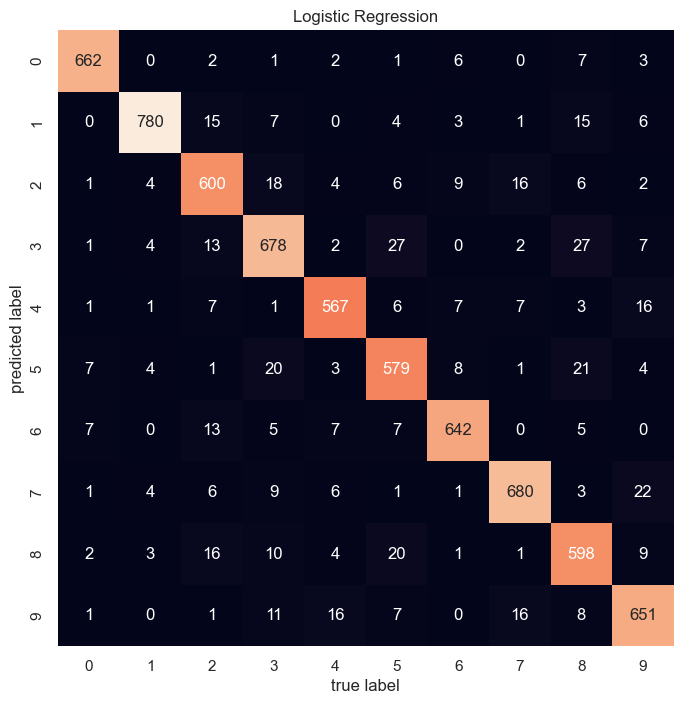

In [10]:
learning_algo = LogisticRegressionLearningAlgorithm(max_iters = 1000)
%time
train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)

# 2. Support Vector Machine + Principal Components Analysis
In this section, we'll investigate the Support Vector Machine with and without dimensionality reduction using PCA.

##  2.1 Basic SVM (Task 1)
In the block below, use Scikit-Learn's SVM classifier, SVC. Configure the SVC with a Radial Basis Function Kernel (RBF), and parameterize the cost value and the RBF gamma parameter.

In [6]:

class RadialBasisSvmLearningAlgorithm(BaseLearningAlgorithm):
  """RBF SVM Classifier function."""

  def __init__(self, cost: float, gamma: float):
    """Initializes the model.
    """
    self.cost = cost
    self.gamma = gamma
    self.model = SVC(C = self.cost, gamma = self.gamma, kernel = 'rbf', verbose = True)

  def fit(self, x_train:np.array, y_train: np.array, x_val:np.array, y_val: np.array) -> None:
    """ Trains a model from labels y and examples X.

    Args:
        x_train (np.array): the training input data
        y_train (np.array): the training output data
        x_val (np.array): the validation input data
        y_val (np.array): the validation output data
    Returns:
        None
    """
    self.model.fit(x_train, y_train)


  def predict(self, x_test: np.array) -> np.array:
    """Predicts on an unlabeled sample, X.

    Args:
        x_test (np.array): the test input data

    Returns:
        np.array: the predicted output data
    """
    return self.model.predict(x_test)

  @property
  def name(self) -> str:
    return 'Radial Basis SVM'

[LibSVM]              precision    recall  f1-score   support

           0       0.97      0.98      0.98       683
           1       0.94      0.98      0.96       800
           2       0.92      0.92      0.92       674
           3       0.91      0.90      0.90       760
           4       0.89      0.94      0.92       611
           5       0.90      0.90      0.90       658
           6       0.95      0.96      0.96       677
           7       0.95      0.94      0.95       724
           8       0.94      0.88      0.91       693
           9       0.93      0.91      0.92       720

    accuracy                           0.93      7000
   macro avg       0.93      0.93      0.93      7000
weighted avg       0.93      0.93      0.93      7000

CPU times: user 8min 5s, sys: 659 ms, total: 8min 6s
Wall time: 8min 21s


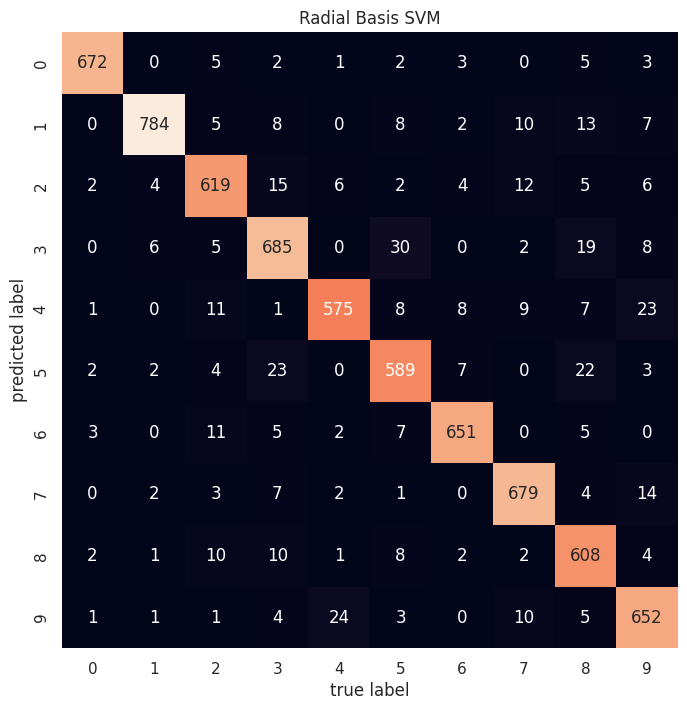

In [9]:
learning_algo = RadialBasisSvmLearningAlgorithm(cost = 10.0, gamma = 0.0001)
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)

##  2.2 Dimensionality Reduction with PCA (Task 2)

Next, we'll use PCA to reduce the input space from 784 dimensions to lower dimensions with lower variance. But how how many dimensions do we choose to keep? To help deceide that, we should first plot out the explained varaince by the number of singular values. This gives us picture of how much information is lost by removing the smallest singular values.  

In the code below, use Scikit-Learn's PCA class with `x_train` and plot out the explained variance ratio against the number of components (singular values).  

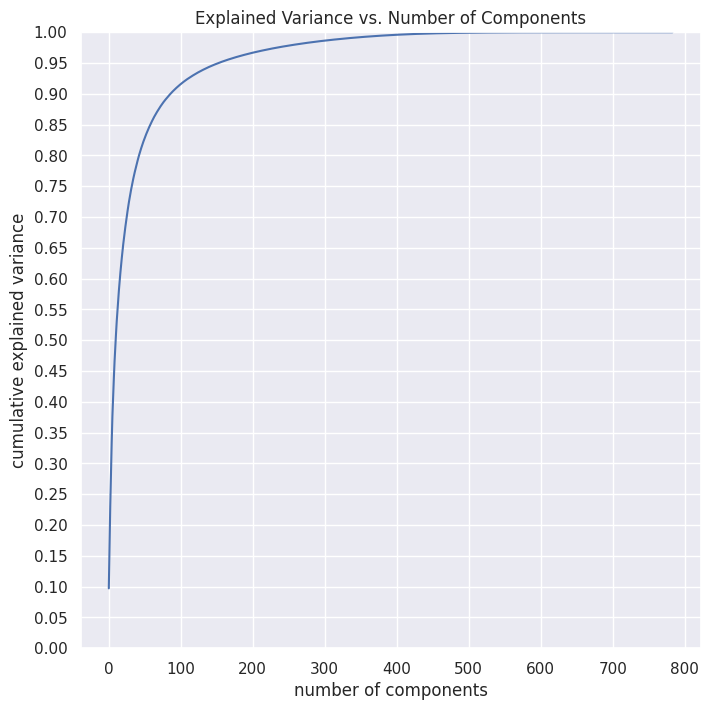

In [10]:
#@title Fit PCA and plot the explained variance as a function of the number of components
pca = PCA().fit(x_train)
exp_var = pca.explained_variance_ratio_

plt.plot(np.cumsum(exp_var))
# Set the y ticks to be at 5% intervals and set the upper limit to 1.0
plt.yticks(np.arange(0, 1.01, step=0.05))
plt.ylim(0,1.0)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Explained Variance vs. Number of Components')
plt.show()

##  [x] Question 2.
Based on the variance vs. num components chart above, how many components represent 80% and 90% of the explained variance?

Here we can the first 100 components explain about 93% of the variance. So we can reduce the dimensionality of the input space by about 7.8 with minimal loss of information. A better judge of the number of components to keep will be the model performance.

As for the 80% and 90% explained variance, let's plot the intersection of the explained variance ratio at this points.

Number of components that explain 80% of the variance:  42
Number of components that explain 90% of the variance:  86


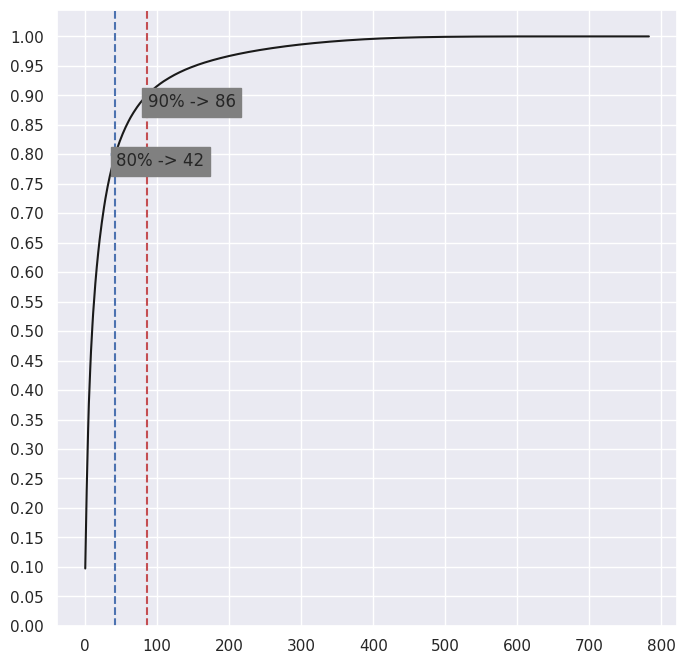

In [11]:
# Get the number of components that explain 80 and 90 percent of the variance
n_components_80 = np.where(np.cumsum(exp_var) > 0.80)[0][0]
n_components_90 = np.where(np.cumsum(exp_var) > 0.90)[0][0]

print('Number of components that explain 80% of the variance: ', n_components_80)
print('Number of components that explain 90% of the variance: ', n_components_90)

# Plot the results on the cumulative variance plot
plt.plot(np.cumsum(exp_var), c='k')
plt.axvline(n_components_80, c='b', linestyle='--')
plt.scatter(n_components_80, 0.80, c='b')
plt.annotate(f'80% -> {n_components_80}', (n_components_80+1, 0.78), backgroundcolor='gray')

plt.axvline(n_components_90, c='r', linestyle='--')
plt.scatter(n_components_90, 0.90, c='r')
plt.annotate(f'90% -> {n_components_90}', (n_components_90+1, 0.88), backgroundcolor='gray')

y_ticks = plt.yticks(np.arange(0, 1.01, step=0.05))


##  [x] 2.2 Apply PCA to reduce dimensionality for SVM (Task 3) 


In the code block below, extend the basic SVM class from 2.1 and name it `RadialBasisSvmPcaLearningAlgorithm` that first reduces the dimension. You can use Scikit-Learn's `make_pipeline()` method to combine PCA and SVC into a pipeline.

In [6]:
class RadialBasisSvmPcaLearningAlgorithm(BaseLearningAlgorithm):
  """RBF SVM Classifier function."""

  def __init__(self, cost: float, gamma: float, num_pca_components: int):
    """Initializes the model. The model is a pipeline that first applies PCA
    and then applies the SVM.

    """
    self.cost = cost
    self.gamma = gamma
    self.num_pca_components = num_pca_components
    self.model = make_pipeline(PCA(n_components = self.num_pca_components),
                               SVC(C = self.cost, gamma = self.gamma, kernel = 'rbf', verbose = True))

  def fit(self, x_train:np.array, y_train: np.array, x_val:np.array, y_val: np.array) -> None:
    """ Trains a model from labels y and examples X.

    Args:
        x_train (np.array): the training input data
        y_train (np.array): the training output data
        x_val (np.array): the validation input data
        y_val (np.array): the validation output data
    Returns:
        None
    """
    self.model.fit(x_train, y_train)


  def predict(self, x_test: np.array) -> np.array:
    """Predicts on an unlabeled sample, X.

    Args:
        x_test (np.array): the test input data

    Returns:
        np.array: the predicted output data
    """
    return self.model.predict(x_test)

  @property
  def name(self) -> str:
    return 'Radial Basis SVM with PCA'

Please implement me
[LibSVM]              precision    recall  f1-score   support

           0       0.96      0.97      0.96       683
           1       0.92      0.98      0.95       800
           2       0.90      0.89      0.90       674
           3       0.89      0.86      0.88       760
           4       0.88      0.93      0.91       611
           5       0.86      0.88      0.87       658
           6       0.93      0.95      0.94       677
           7       0.94      0.92      0.93       724
           8       0.91      0.84      0.87       693
           9       0.91      0.88      0.89       720

    accuracy                           0.91      7000
   macro avg       0.91      0.91      0.91      7000
weighted avg       0.91      0.91      0.91      7000

CPU times: user 59.9 s, sys: 1.12 s, total: 1min 1s
Wall time: 1min


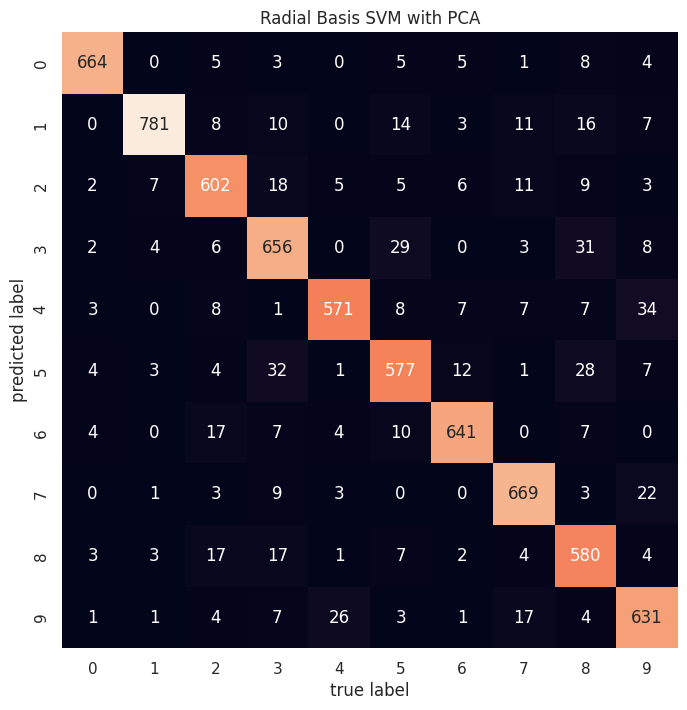

In [ ]:
learning_algo = RadialBasisSvmPcaLearningAlgorithm(num_pca_components=30, cost = 10.0, gamma = 0.0001)
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)


##  [x] Question 3.
What is the minimum number of components required to achieve equivalent performance to basic SVM without PCA (2.1)?

In order to answer this question, we need to evaluate the performance of the PCA-SVM model at various number of components.

In [8]:
# Initiate a dataframe to store the results
results = pd.DataFrame(columns=['cost', 'gamma', 'num_pca_components', 'accuracy'])

cost_list = [0.1, 1.0, 10.0, 100.0]
gamma_list = [0.0001, 0.001, 0.01, 0.1]
num_pca_components_list = [50, 75, 85, 90, 95]

for cost in cost_list:
  for gamma in gamma_list:
    for num_pca_components in num_pca_components_list:
      learning_algo = RadialBasisSvmPcaLearningAlgorithm(num_pca_components=num_pca_components, cost = cost, gamma = gamma)
      print('Training with cost = ', cost, ', gamma = ', gamma, ', num_pca_components = ', num_pca_components)
      try:
        learning_algo.fit(x_train, y_train, x_val, y_val)
      except:
        print('Training failed.')
        continue
      y_pred = learning_algo.predict(x_test)

      accuracy = accuracy_score(y_test, y_pred)
      f1 = f1_score(y_test, y_pred, average='macro')


      new_row = pd.DataFrame([{'cost': cost, 'gamma': gamma, 'num_pca_components': num_pca_components,
                         'accuracy': accuracy, 'f1_score': f1}])
      results = pd.concat([results, new_row], ignore_index=True)



Training with cost =  0.1 , gamma =  0.0001 , num_pca_components =  50


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  0.1 , gamma =  0.0001 , num_pca_components =  75


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  0.1 , gamma =  0.0001 , num_pca_components =  85


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  0.1 , gamma =  0.0001 , num_pca_components =  90


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  0.1 , gamma =  0.0001 , num_pca_components =  95


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  0.1 , gamma =  0.001 , num_pca_components =  50


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  0.1 , gamma =  0.001 , num_pca_components =  75


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  0.1 , gamma =  0.001 , num_pca_components =  85


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  0.1 , gamma =  0.001 , num_pca_components =  90


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  0.1 , gamma =  0.001 , num_pca_components =  95


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  0.1 , gamma =  0.01 , num_pca_components =  50


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  0.1 , gamma =  0.01 , num_pca_components =  75


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  0.1 , gamma =  0.01 , num_pca_components =  85


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  0.1 , gamma =  0.01 , num_pca_components =  90


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  0.1 , gamma =  0.01 , num_pca_components =  95


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  0.1 , gamma =  0.1 , num_pca_components =  50


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  0.1 , gamma =  0.1 , num_pca_components =  75


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  0.1 , gamma =  0.1 , num_pca_components =  85


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  0.1 , gamma =  0.1 , num_pca_components =  90


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  0.1 , gamma =  0.1 , num_pca_components =  95


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  1.0 , gamma =  0.0001 , num_pca_components =  50


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  1.0 , gamma =  0.0001 , num_pca_components =  75


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  1.0 , gamma =  0.0001 , num_pca_components =  85


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  1.0 , gamma =  0.0001 , num_pca_components =  90


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  1.0 , gamma =  0.0001 , num_pca_components =  95


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  1.0 , gamma =  0.001 , num_pca_components =  50


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  1.0 , gamma =  0.001 , num_pca_components =  75


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  1.0 , gamma =  0.001 , num_pca_components =  85


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  1.0 , gamma =  0.001 , num_pca_components =  90


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  1.0 , gamma =  0.001 , num_pca_components =  95


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  1.0 , gamma =  0.01 , num_pca_components =  50


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  1.0 , gamma =  0.01 , num_pca_components =  75


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  1.0 , gamma =  0.01 , num_pca_components =  85


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  1.0 , gamma =  0.01 , num_pca_components =  90


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  1.0 , gamma =  0.01 , num_pca_components =  95


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  1.0 , gamma =  0.1 , num_pca_components =  50


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  1.0 , gamma =  0.1 , num_pca_components =  75


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  1.0 , gamma =  0.1 , num_pca_components =  85


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  1.0 , gamma =  0.1 , num_pca_components =  90


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  1.0 , gamma =  0.1 , num_pca_components =  95


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  10.0 , gamma =  0.0001 , num_pca_components =  50


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  10.0 , gamma =  0.0001 , num_pca_components =  75


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  10.0 , gamma =  0.0001 , num_pca_components =  85


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  10.0 , gamma =  0.0001 , num_pca_components =  90


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  10.0 , gamma =  0.0001 , num_pca_components =  95


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  10.0 , gamma =  0.001 , num_pca_components =  50


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  10.0 , gamma =  0.001 , num_pca_components =  75


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  10.0 , gamma =  0.001 , num_pca_components =  85


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  10.0 , gamma =  0.001 , num_pca_components =  90


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  10.0 , gamma =  0.001 , num_pca_components =  95


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  10.0 , gamma =  0.01 , num_pca_components =  50


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  10.0 , gamma =  0.01 , num_pca_components =  75


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  10.0 , gamma =  0.01 , num_pca_components =  85


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  10.0 , gamma =  0.01 , num_pca_components =  90


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  10.0 , gamma =  0.01 , num_pca_components =  95


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  10.0 , gamma =  0.1 , num_pca_components =  50


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  10.0 , gamma =  0.1 , num_pca_components =  75


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  10.0 , gamma =  0.1 , num_pca_components =  85


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  10.0 , gamma =  0.1 , num_pca_components =  90


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  10.0 , gamma =  0.1 , num_pca_components =  95


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  100.0 , gamma =  0.0001 , num_pca_components =  50


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  100.0 , gamma =  0.0001 , num_pca_components =  75


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  100.0 , gamma =  0.0001 , num_pca_components =  85


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  100.0 , gamma =  0.0001 , num_pca_components =  90


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  100.0 , gamma =  0.0001 , num_pca_components =  95


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  100.0 , gamma =  0.001 , num_pca_components =  50


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  100.0 , gamma =  0.001 , num_pca_components =  75


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  100.0 , gamma =  0.001 , num_pca_components =  85


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  100.0 , gamma =  0.001 , num_pca_components =  90


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  100.0 , gamma =  0.001 , num_pca_components =  95


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  100.0 , gamma =  0.01 , num_pca_components =  50


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  100.0 , gamma =  0.01 , num_pca_components =  75


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  100.0 , gamma =  0.01 , num_pca_components =  85


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  100.0 , gamma =  0.01 , num_pca_components =  90


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  100.0 , gamma =  0.01 , num_pca_components =  95


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  100.0 , gamma =  0.1 , num_pca_components =  50


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  100.0 , gamma =  0.1 , num_pca_components =  75


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  100.0 , gamma =  0.1 , num_pca_components =  85


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  100.0 , gamma =  0.1 , num_pca_components =  90


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Training with cost =  100.0 , gamma =  0.1 , num_pca_components =  95


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[LibSVM]

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

In [ ]:
# Save the results to a csv file
results.to_csv('results_pcasvm.csv', index=False)

Now that we have conducted an extensive evaluation of the PCA-SVM model, we can answer the question above. For this we will simply select all the parameters that have an F1-Score within 1% of the basic SVM model, i.e betwwen 92 and 94% for accuracy.

In [23]:
# Let's filter the results to include the range we are interested in
results_comp = results[(results['accuracy'] >= 0.93) & (results['accuracy'] < 0.94)]
results_comp.sort_values(by=['num_pca_components'])

,cost,gamma,num_pca_components,accuracy,f1_score
26,1.0,0.0010,75,0.931857,0.931308
61,100.0,0.0001,75,0.934429,0.933853
27,1.0,0.0010,85,0.930857,0.930255
62,100.0,0.0001,85,0.936429,0.935842
28,1.0,0.0010,90,0.930714,0.930160
63,100.0,0.0001,90,0.936714,0.936248
29,1.0,0.0010,95,0.932000,0.931447
64,100.0,0.0001,95,0.937857,0.937377


*Answer:* **We can see that the minimum number of components required to achieve equivalent performance to basic SVM without PCA is 75 when the following parameters are used:**
- C = 1.0
- gamma = 0.001

Now, let's analyze the modelling results to see if we can gain any insights into how these hyperparameters affect the performance.

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

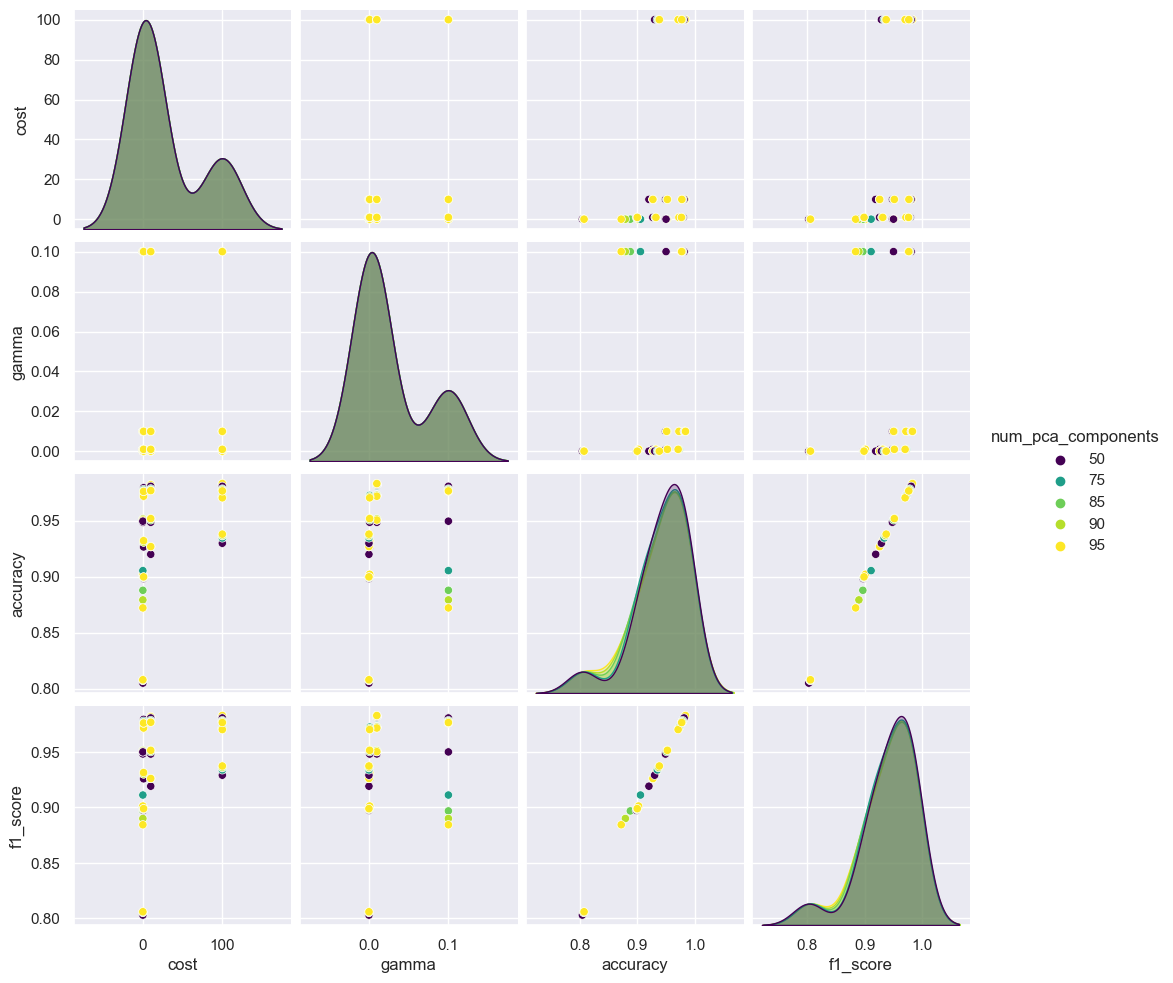

In [19]:
# We'll plot a pairplot to see if there are any interesting relationships
sns.pairplot(results, hue='num_pca_components', palette='viridis')

# 3. Random Forest

In this section, we'll investigate the Random Forest algorithm that aggregates its answer using many decorrelated trees.

##  [x] 3.1 Tuning the Random Forest (Task 4)
In the code black below, write an extension class to `BaseLearningAlgorithm` called `RandomForestLearningAlgorithm` using Scikit-Learn's RandomForestClassifier. You should parameterize the class with the number of estimators (i.e., number of trees), type of split (gini or entropy), max tree depth, minimum number of samples per node.

Without doing a formal hyperparameter tuning, like grid search, try a few variations to improve overall accuracy.

In [19]:
class RandomForestLearningAlgorithm(BaseLearningAlgorithm):
    """Random Forest Classifier function."""

    def __init__(self, num_trees: int, criterion: str, max_depth: int, min_samples_split: int):
        """Initializes the model.
        """
        self.num_trees = num_trees
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split

        self.model = RandomForestClassifier(n_estimators = self.num_trees, criterion = self.criterion,
                                            max_depth = self.max_depth, min_samples_split = self.min_samples_split, verbose = True)

    def fit(self, x_train:np.array, y_train: np.array, x_val:np.array, y_val: np.array) -> None:
        """ Trains a model from labels y and examples X.

        Args:
            x_train (np.array): the training input data
            y_train (np.array): the training output data
            x_val (np.array): the validation input data
            y_val (np.array): the validation output data
        Returns:
            None
        """
        self.model.fit(x_train, y_train)


    def predict(self, x_test: np.array) -> np.array:
        """Predicts on an unlabeled sample, X.

        Args:
            x_test (np.array): the test input data

        Returns:
            np.array: the predicted output data
        """
        return self.model.predict(x_test)

    @property
    def name(self) -> str:
        return 'Random Forest'

In [20]:
# Define the hyperparameters to be tuned
n_estimators_list = [50, 100, 150, 200]
max_depth_list = [5, 10]
min_samples_split_list = [2, 5]
criterion_list = ["gini", "entropy"]
num_total_trials = (
    len(n_estimators_list)
    * len(max_depth_list)
    * len(min_samples_split_list)
    * len(criterion_list)
)

# Initiate a dataframe to store the results
results_rf = pd.DataFrame(
    columns=[
        "n_estimators",
        "max_depth",
        "min_samples_split",
        "criterion",
        "accuracy",
        "f1_score",
    ]
)

no_trial = 0
# Initiate Grid Search
for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        for min_samples_split in min_samples_split_list:
            for criterion in criterion_list:
                learning_algo = RandomForestLearningAlgorithm(
                    num_trees=n_estimators,
                    criterion=criterion,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                )
                print(f">>> Trial {no_trial+1}/{num_total_trials}")
                print(
                    f">>> n_estimators = {n_estimators}, max_depth = {max_depth}, min_samples_split = {min_samples_split}, criterion = {criterion}"
                )
                try:
                    learning_algo.fit(x_train, y_train, x_val, y_val)
                except:
                    print("Training failed.")
                    continue
                y_pred = learning_algo.predict(x_test)

                accuracy = accuracy_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred, average="macro")

                new_row = pd.DataFrame(
                    [
                        {
                            "n_estimators": n_estimators,
                            "max_depth": max_depth,
                            "min_samples_split": min_samples_split,
                            "criterion": criterion,
                            "accuracy": accuracy,
                            "f1_score": f1,
                        }
                    ]
                )
                
                results_rf = pd.concat([results_rf, new_row], ignore_index=True)
                no_trial += 1

>>> Trial 1/32
>>> n_estimators = 50, max_depth = 5, min_samples_split = 2, criterion = gini


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    6.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning

>>> Trial 2/32
>>> n_estimators = 50, max_depth = 5, min_samples_split = 2, criterion = entropy


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    7.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning

>>> Trial 3/32
>>> n_estimators = 50, max_depth = 5, min_samples_split = 5, criterion = gini


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    6.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning

>>> Trial 4/32
>>> n_estimators = 50, max_depth = 5, min_samples_split = 5, criterion = entropy


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    7.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning

>>> Trial 5/32
>>> n_estimators = 50, max_depth = 10, min_samples_split = 2, criterion = gini


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   11.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning

>>> Trial 6/32
>>> n_estimators = 50, max_depth = 10, min_samples_split = 2, criterion = entropy


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   15.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning

>>> Trial 7/32
>>> n_estimators = 50, max_depth = 10, min_samples_split = 5, criterion = gini


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   11.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning

>>> Trial 8/32
>>> n_estimators = 50, max_depth = 10, min_samples_split = 5, criterion = entropy


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   15.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning

>>> Trial 9/32
>>> n_estimators = 100, max_depth = 5, min_samples_split = 2, criterion = gini


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning

>>> Trial 10/32
>>> n_estimators = 100, max_depth = 5, min_samples_split = 2, criterion = entropy


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    7.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning

>>> Trial 11/32
>>> n_estimators = 100, max_depth = 5, min_samples_split = 5, criterion = gini


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning

>>> Trial 12/32
>>> n_estimators = 100, max_depth = 5, min_samples_split = 5, criterion = entropy


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    7.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning

>>> Trial 13/32
>>> n_estimators = 100, max_depth = 10, min_samples_split = 2, criterion = gini


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   11.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning

>>> Trial 14/32
>>> n_estimators = 100, max_depth = 10, min_samples_split = 2, criterion = entropy


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   15.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning

>>> Trial 15/32
>>> n_estimators = 100, max_depth = 10, min_samples_split = 5, criterion = gini


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   11.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning

>>> Trial 16/32
>>> n_estimators = 100, max_depth = 10, min_samples_split = 5, criterion = entropy


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   16.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning

>>> Trial 17/32
>>> n_estimators = 150, max_depth = 5, min_samples_split = 2, criterion = gini


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    6.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning

>>> Trial 18/32
>>> n_estimators = 150, max_depth = 5, min_samples_split = 2, criterion = entropy


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    7.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning

>>> Trial 19/32
>>> n_estimators = 150, max_depth = 5, min_samples_split = 5, criterion = gini


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    6.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning

>>> Trial 20/32
>>> n_estimators = 150, max_depth = 5, min_samples_split = 5, criterion = entropy


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    7.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning

>>> Trial 21/32
>>> n_estimators = 150, max_depth = 10, min_samples_split = 2, criterion = gini


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   12.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning

>>> Trial 22/32
>>> n_estimators = 150, max_depth = 10, min_samples_split = 2, criterion = entropy


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   15.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning

>>> Trial 23/32
>>> n_estimators = 150, max_depth = 10, min_samples_split = 5, criterion = gini


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   11.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning

>>> Trial 24/32
>>> n_estimators = 150, max_depth = 10, min_samples_split = 5, criterion = entropy


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   15.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning

>>> Trial 25/32
>>> n_estimators = 200, max_depth = 5, min_samples_split = 2, criterion = gini


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    6.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   24.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if 

>>> Trial 26/32
>>> n_estimators = 200, max_depth = 5, min_samples_split = 2, criterion = entropy


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    7.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   28.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if 

>>> Trial 27/32
>>> n_estimators = 200, max_depth = 5, min_samples_split = 5, criterion = gini


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    6.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   24.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if 

>>> Trial 28/32
>>> n_estimators = 200, max_depth = 5, min_samples_split = 5, criterion = entropy


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    7.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   29.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if 

>>> Trial 29/32
>>> n_estimators = 200, max_depth = 10, min_samples_split = 2, criterion = gini


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   11.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   46.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if 

>>> Trial 30/32
>>> n_estimators = 200, max_depth = 10, min_samples_split = 2, criterion = entropy


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   15.5s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if 

>>> Trial 31/32
>>> n_estimators = 200, max_depth = 10, min_samples_split = 5, criterion = gini


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   11.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   50.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if 

>>> Trial 32/32
>>> n_estimators = 200, max_depth = 10, min_samples_split = 5, criterion = entropy


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   17.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if 

Let's analyze the results and see the combination of parameters that yield the top 5 results.

In [21]:
# We will sort the results by accuracy and f1_score to see the best results
results_rf.sort_values(by=["accuracy", "f1_score"], ascending=False)

,n_estimators,max_depth,min_samples_split,criterion,accuracy,f1_score
21,150,10,2,entropy,0.948143,0.948102
15,100,10,5,entropy,0.946571,0.946490
31,200,10,5,entropy,0.946143,0.945968
29,200,10,2,entropy,0.945857,0.945740
13,100,10,2,entropy,0.945714,0.945512
20,150,10,2,gini,0.945571,0.945556
23,150,10,5,entropy,0.945571,0.945520
30,200,10,5,gini,0.945429,0.945360
22,150,10,5,gini,0.945143,0.945062
14,100,10,5,gini,0.944857,0.944768


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

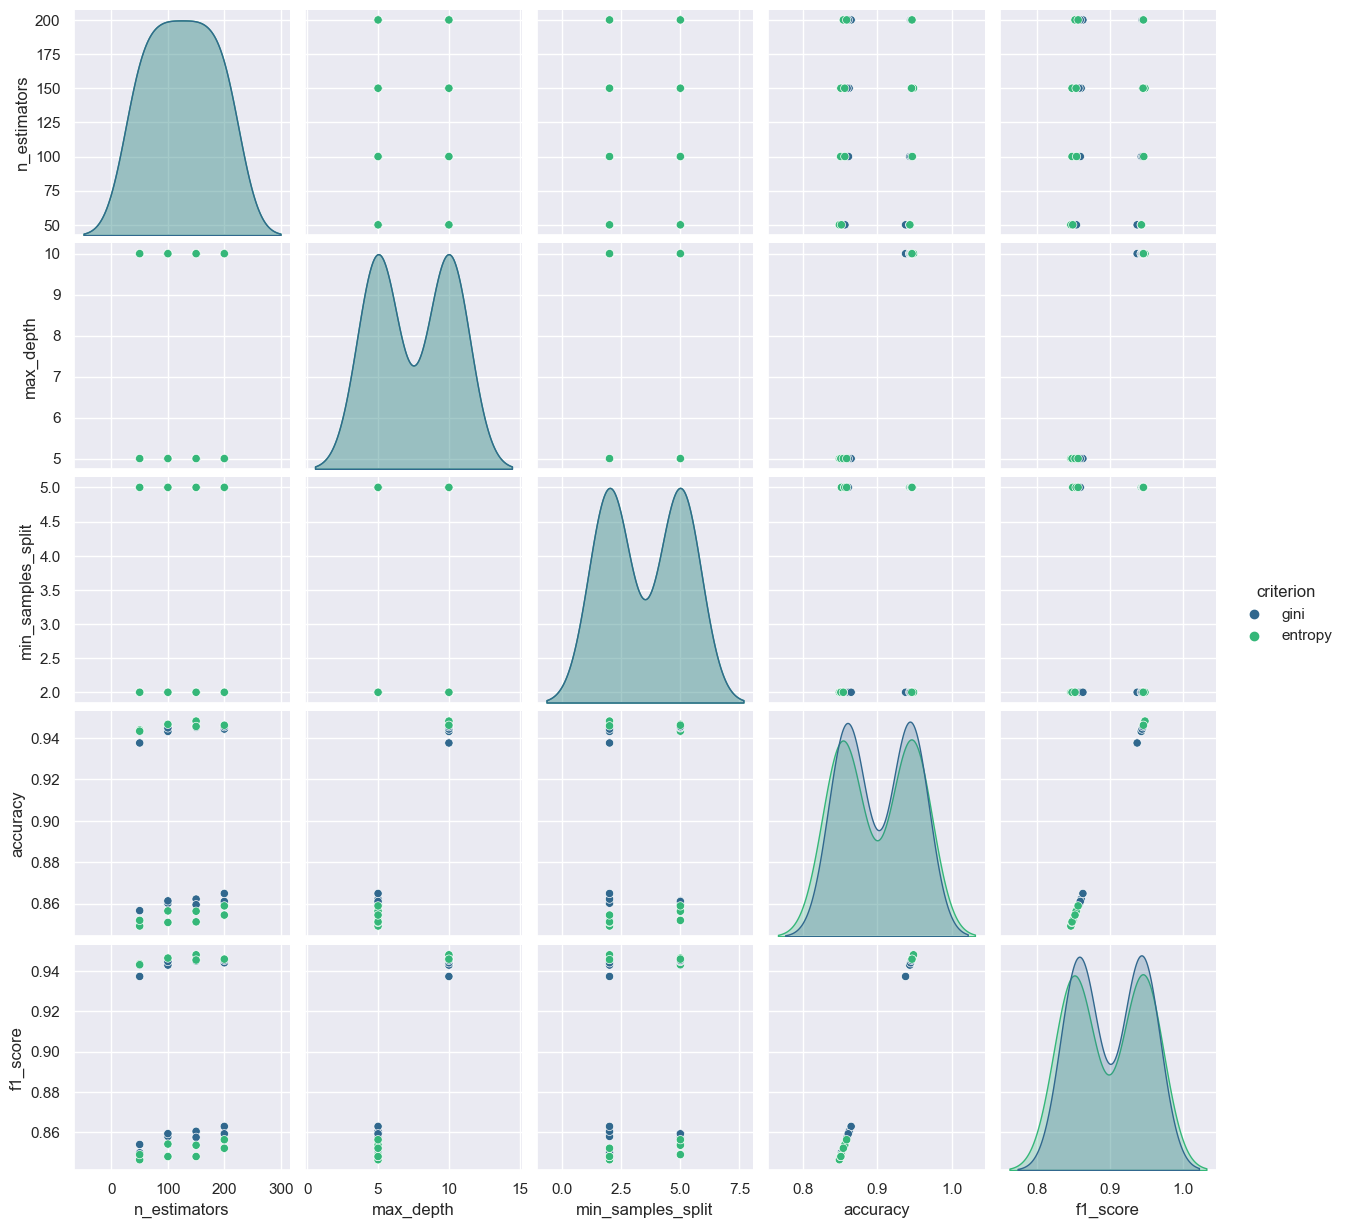

In [22]:
# Let's plot a pairplot for the Random Forest results as well
sns.pairplot(results_rf, hue='criterion', palette='viridis') 

Judging by the above parameters, we can see that max_depth is the hyperparamter with the most influence on the model performance. This is not surprising since the max_depth controls the depth of the tree, and thus the number of splits. The number of estimators. in this case, the number of trees, also has a noticeable impact albeit being far less dramatic than max_depth.

Moreover, we can see that our model could benefit from increasing the maximum allowed depth from 10 to around 20. So we will do that in the next trial.

Another interesting observation is that the choice of criterion, i.e. gini or entropy, has a hard to detect impact. Looking closely, we can see that with lower max_depth values, gini performs better, while the opposite is true for higher max_depth values. This is probably due to the fact that entropy is more sensitive to outliers, and thus performs better with more complex models.


## [x] Question 4.
What are the top three pairs of confusion (i.e., true row $i$, predicted column $j$), and are they the same as SVM? Why are these classes confused with each other?

Let's test this by evaluating the model with the best hyperparameters on the test set.

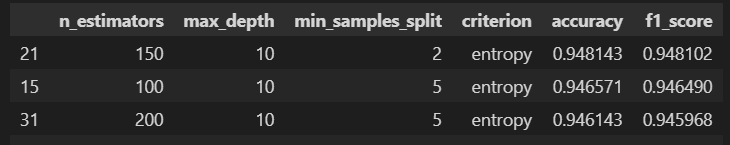

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   16.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       683
           1       0.96      0.98      0.97       800
           2       0.93      0.95      0.94       674
           3       0.94      0.92      0.93       760
           4       0.94      0.94      0.94       611
           5       0.97      0.93      0.95       658
           6       0.96      0.98      0.97       677
           7       0.95      0.94      0.94       724
           8       0.93      0.92      0.93       693
           9       0.91      0.92      0.91       720

    accuracy                           0.95      7000
   macro avg       0.95      0.95      0.95      7000
weighted avg       0.95      0.95      0.95      7000



{'accuracy': 0.9461428571428572, 'f1_score': 0.9460477390724729}

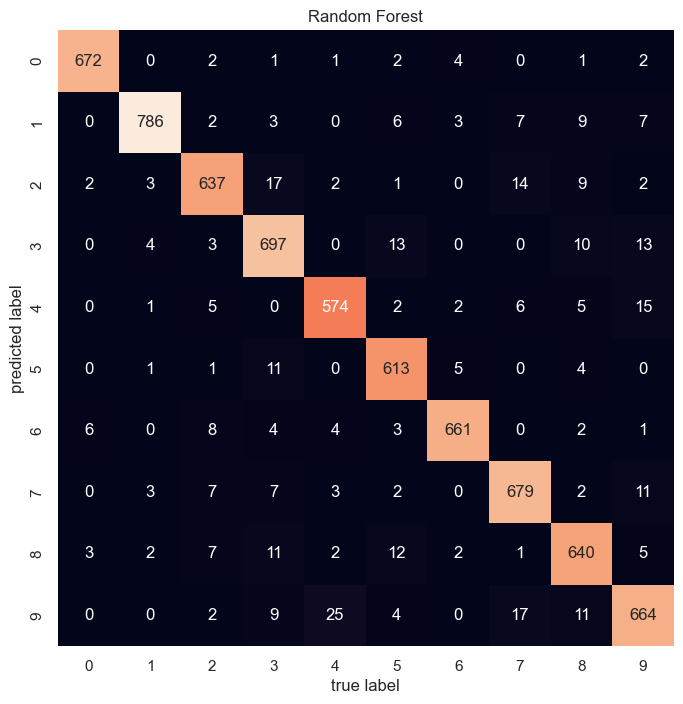

In [20]:
best_n_estimators = 150
best_max_depth = 10
best_min_samples_split = 2
best_criterion = 'entropy'

rf_learning_algo = RandomForestLearningAlgorithm(num_trees=best_n_estimators,
                                                    criterion=best_criterion,
                                                    max_depth=best_max_depth,
                                                    min_samples_split=best_min_samples_split)

train_eval(rf_learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)

Above, we can see the results ofthe best RF model on the test set. Below, the SVM model results are given for comparison:
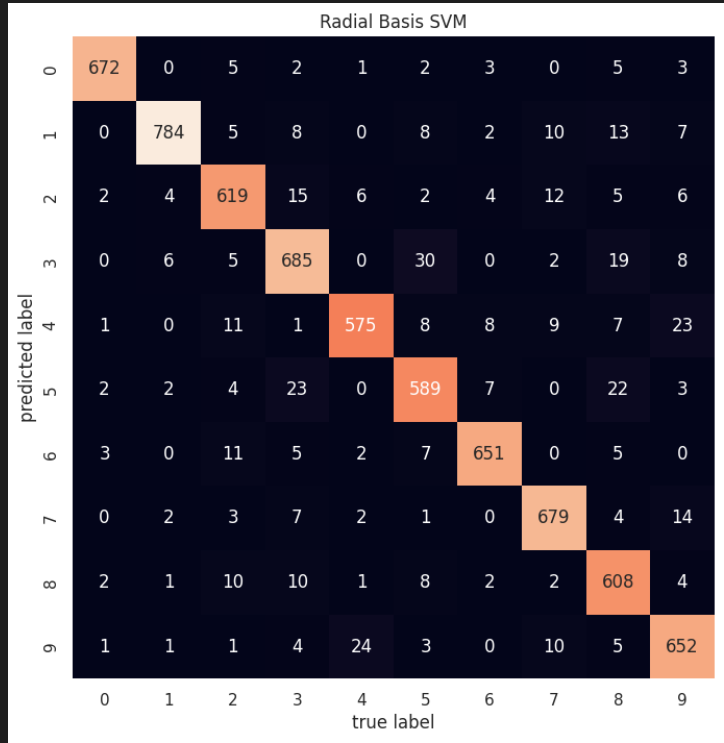

Comparing the two confusion matrices, both mdoels seem to be confusing 4 and 9, which is understandable since they are both similar in shape. However, the RF model seems to be confusing 7 and 8 with 9 as well. We can clearly see that the RF model is more prone to confusing 9 with other numbers than the SVM model. The next highest confusion is between 3 and 5, which is not surprising as they are rather close to each other in shape as well. 

What's interesting is thatthe SVM model is more prone to confusing 3 with 5 than the RF model with the erroneous predictions being more than 2 tiems more frequent. Another noteworthy observation is that the SVM model seems to be confusing 2 with a lot of other numbers, while the RF model is not. Let's check the distribution of classes in the dataset to see if this is due to the fact that 2 is underrepresented in the dataset.

In [23]:
# Let's see the number of sampels per class
y_train.value_counts().sort_values()

class
5    5051
8    5501
0    5612
4    5626
9    5635
6    5654
2    5693
3    5730
7    5877
1    6321
Name: count, dtype: int64

Apparently, 2 is not underrepresented in the dataset, in fact we cannot attribute the high number of erroneous predictions to the class distribution at all

# 4. Feedforward Neural Networks

In this section, we'll explore feedforward neural networks. First, we'll make some enhancements to a NN written using just numpy to give you a sense for how forward and back-propagation work, and how the weights are optimized using basic gradient descent.



## [x] 4.1 Neural network without libraries (Task 5)
Study the complete neural network implementation below. The architecture has an input width of 784 nodes, two hidden layers, and a softmax output layer of with 10 nodes (0-9).
Pay attention to the gradient calculation and the overall backpropagation algorithm, and how gradient descent adjusts the weights. Implement the ReLU activation funtion in the skeleton method provided below and compare the results to the sigmoid activation function.

In [13]:
#@title Basic Neural Network Algorithm

class DeepNeuralNetworkLearningAlgorithm(BaseLearningAlgorithm):
    def __init__(self, sizes, epochs=10, l_rate=0.001, activation='sigmoid'):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate
        self.activation = activation
        # Save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def relu(self, x, derivative=False):
      if derivative:
        return 1. * (x > 0)     
      
      return np.maximum(0, x)

    def softmax(self, x, derivative=False):
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def initialization(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params

    def forward_pass(self, x_train: np.array) -> np.array:
        params = self.params

        # input layer activations becomes sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        params['Z1'] = np.dot(params["W1"], params['A0'])
        params['A1'] = self.sigmoid(params['Z1']) if self.activation == 'sigmoid' else self.relu(params['Z1'])

        # hidden layer 1 to hidden layer 2
        params['Z2'] = np.dot(params["W2"], params['A1'])
        params['A2'] = self.sigmoid(params['Z2']) if self.activation == 'sigmoid' else self.relu(params['Z2'])

        # hidden layer 2 to output layer
        params['Z3'] = np.dot(params["W3"], params['A2'])
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_train: np.array, output: np.array) -> Dict[str, np.array]:
        """Perfoms backpropagation."""
        params = self.params
        change_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
        change_w['W3'] = np.outer(error, params['A2'])

        # Calculate W2 update
        error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
        change_w['W2'] = np.outer(error, params['A1'])

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
        change_w['W1'] = np.outer(error, params['A0'])

        return change_w

    def update_network_parameters(self, changes_to_w: Dict[str, np.array]):
        """Updates network parameters according to update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y),
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        """

        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        """
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output equals the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        """
        predictions = []
        y_val = to_categorical(y_val)
        for x, y in zip(x_val, y_val):

            output = self.forward_pass(x)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))

        return np.mean(predictions)

    def predict(self, X_test: np.array) -> np.array:
      """Predicts on a test set."""
      return np.array([str(np.argmax(self.forward_pass(x))) for x in X_test])

    def fit(self, x_train, y_train, x_val, y_val):
        """ Trains a model from labels y and examples X.
        This implements the stochastic gradient descent learning algorithm with 
        Early Stopping.

        Args:
            x_train (_type_): _description_
            y_train (_type_): _description_
            x_val (_type_): _description_
            y_val (_type_): _description_
        """
        
        y_train = to_categorical(y_train)
        start_time = time.time()
        for iteration in range(self.epochs):
            for x,y in zip(x_train, y_train):

                output = self.forward_pass(x)

                changes_to_w = self.backward_pass(y, output)
                self.update_network_parameters(changes_to_w)

            accuracy = self.compute_accuracy(x_val, y_val)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Validation Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, accuracy * 100
            ))
    @property
    def name(self) -> str:
      return 'Basic Neural Network'


In [14]:
# Define the hyperparameters to be tuned
activation_list = ["relu", "sigmoid"]
epochs_list = [10, 20, 30]
l_rate_list = [0.001, 0.01, 0.1]

num_total_trials = len(activation_list) * len(epochs_list) * len(l_rate_list)

# Initialize a dataframe to store the results
results_nn = pd.DataFrame(columns=["sizes", "activation", "accuracy", "f1_score"])

# Intialize the Grid Search
no_trial = 0

for activation in activation_list:
    for epochs in epochs_list:
        for l_rate in l_rate_list:
            learning_algo = DeepNeuralNetworkLearningAlgorithm(
                sizes=[784, 128, 64, 10],
                epochs=epochs,
                l_rate=l_rate,
                activation=activation,
            )
            print(f">>> Trial {no_trial+1}/{num_total_trials}")
            no_trial += 1
            print(
                f">>> activation = {activation}, epochs = {epochs}, l_rate = {l_rate}"
            )
            # try:
            #     learning_algo.fit(x_train, y_train, x_val, y_val)
            # except:
            #     print("Training failed.")
            #     new_row = pd.DataFrame(
            #         [
            #             {
            #                 "sizes": [784, 128, 64, 10],
            #                 "activation": activation,
            #                 "accuracy": np.nan,
            #                 "f1_score": np.nan,
            #             }
            #         ]
            #     )
                
            #     pd.concat([results_nn, new_row], ignore_index=True)
                
            #     continue
            learning_algo.fit(x_train, y_train, x_val, y_val)
            
            
            y_pred = learning_algo.predict(x_test)

            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average="macro")

            new_row = pd.DataFrame(
                [
                    {
                        "sizes": [784, 128, 64, 10],
                        "activation": activation,
                        "epochs": epochs,
                        "l_rate": l_rate,
                        "accuracy": accuracy,
                        "f1_score": f1,
                    }
                ]
            )

            results_nn = pd.concat([results_nn, new_row], ignore_index=True)

>>> Trial 1/18
>>> activation = relu, epochs = 10, l_rate = 0.001
Epoch: 1, Time Spent: 16.51s, Validation Accuracy: 31.75%
Epoch: 2, Time Spent: 32.78s, Validation Accuracy: 49.95%
Epoch: 3, Time Spent: 50.17s, Validation Accuracy: 59.40%
Epoch: 4, Time Spent: 67.38s, Validation Accuracy: 65.83%
Epoch: 5, Time Spent: 85.24s, Validation Accuracy: 70.63%
Epoch: 6, Time Spent: 101.83s, Validation Accuracy: 73.79%
Epoch: 7, Time Spent: 119.35s, Validation Accuracy: 76.10%
Epoch: 8, Time Spent: 136.89s, Validation Accuracy: 78.03%
Epoch: 9, Time Spent: 155.11s, Validation Accuracy: 79.59%
Epoch: 10, Time Spent: 174.18s, Validation Accuracy: 80.92%


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

>>> Trial 2/18
>>> activation = relu, epochs = 10, l_rate = 0.01
Epoch: 1, Time Spent: 22.29s, Validation Accuracy: 78.70%
Epoch: 2, Time Spent: 38.92s, Validation Accuracy: 84.52%
Epoch: 3, Time Spent: 57.45s, Validation Accuracy: 87.22%
Epoch: 4, Time Spent: 76.48s, Validation Accuracy: 88.21%
Epoch: 5, Time Spent: 92.38s, Validation Accuracy: 88.81%
Epoch: 6, Time Spent: 109.98s, Validation Accuracy: 89.33%
Epoch: 7, Time Spent: 126.53s, Validation Accuracy: 89.79%
Epoch: 8, Time Spent: 142.51s, Validation Accuracy: 90.10%
Epoch: 9, Time Spent: 159.11s, Validation Accuracy: 90.46%
Epoch: 10, Time Spent: 175.35s, Validation Accuracy: 90.70%


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

>>> Trial 3/18
>>> activation = relu, epochs = 10, l_rate = 0.1
Epoch: 1, Time Spent: 17.35s, Validation Accuracy: 90.00%
Epoch: 2, Time Spent: 34.91s, Validation Accuracy: 91.59%
Epoch: 3, Time Spent: 51.72s, Validation Accuracy: 91.76%
Epoch: 4, Time Spent: 70.73s, Validation Accuracy: 90.56%
Epoch: 5, Time Spent: 90.16s, Validation Accuracy: 79.56%
Epoch: 6, Time Spent: 109.24s, Validation Accuracy: 84.49%
Epoch: 7, Time Spent: 128.88s, Validation Accuracy: 85.17%
Epoch: 8, Time Spent: 147.15s, Validation Accuracy: 80.84%
Epoch: 9, Time Spent: 165.47s, Validation Accuracy: 76.60%
Epoch: 10, Time Spent: 183.64s, Validation Accuracy: 72.22%


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

>>> Trial 4/18
>>> activation = relu, epochs = 20, l_rate = 0.001
Epoch: 1, Time Spent: 18.24s, Validation Accuracy: 29.19%
Epoch: 2, Time Spent: 37.56s, Validation Accuracy: 43.65%
Epoch: 3, Time Spent: 55.79s, Validation Accuracy: 53.14%
Epoch: 4, Time Spent: 74.86s, Validation Accuracy: 59.86%
Epoch: 5, Time Spent: 92.66s, Validation Accuracy: 66.10%
Epoch: 6, Time Spent: 110.10s, Validation Accuracy: 71.83%
Epoch: 7, Time Spent: 127.74s, Validation Accuracy: 75.46%
Epoch: 8, Time Spent: 145.28s, Validation Accuracy: 77.54%
Epoch: 9, Time Spent: 162.09s, Validation Accuracy: 79.43%
Epoch: 10, Time Spent: 179.53s, Validation Accuracy: 80.73%
Epoch: 11, Time Spent: 199.00s, Validation Accuracy: 81.79%
Epoch: 12, Time Spent: 217.64s, Validation Accuracy: 82.41%
Epoch: 13, Time Spent: 235.15s, Validation Accuracy: 83.06%
Epoch: 14, Time Spent: 251.98s, Validation Accuracy: 83.52%
Epoch: 15, Time Spent: 269.59s, Validation Accuracy: 84.16%
Epoch: 16, Time Spent: 286.56s, Validation Accur

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

>>> Trial 5/18
>>> activation = relu, epochs = 20, l_rate = 0.01
Epoch: 1, Time Spent: 18.83s, Validation Accuracy: 79.19%
Epoch: 2, Time Spent: 36.69s, Validation Accuracy: 85.17%
Epoch: 3, Time Spent: 53.93s, Validation Accuracy: 87.27%
Epoch: 4, Time Spent: 71.78s, Validation Accuracy: 88.37%
Epoch: 5, Time Spent: 91.16s, Validation Accuracy: 89.19%
Epoch: 6, Time Spent: 112.60s, Validation Accuracy: 89.57%
Epoch: 7, Time Spent: 131.02s, Validation Accuracy: 90.02%
Epoch: 8, Time Spent: 148.54s, Validation Accuracy: 90.13%
Epoch: 9, Time Spent: 167.68s, Validation Accuracy: 90.46%
Epoch: 10, Time Spent: 187.26s, Validation Accuracy: 90.63%
Epoch: 11, Time Spent: 207.07s, Validation Accuracy: 90.86%
Epoch: 12, Time Spent: 226.39s, Validation Accuracy: 90.89%
Epoch: 13, Time Spent: 244.31s, Validation Accuracy: 91.11%
Epoch: 14, Time Spent: 263.17s, Validation Accuracy: 91.19%
Epoch: 15, Time Spent: 282.34s, Validation Accuracy: 91.44%
Epoch: 16, Time Spent: 304.13s, Validation Accura

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

>>> Trial 6/18
>>> activation = relu, epochs = 20, l_rate = 0.1
Epoch: 1, Time Spent: 17.38s, Validation Accuracy: 89.84%
Epoch: 2, Time Spent: 34.00s, Validation Accuracy: 91.48%
Epoch: 3, Time Spent: 52.15s, Validation Accuracy: 92.11%
Epoch: 4, Time Spent: 71.67s, Validation Accuracy: 92.29%
Epoch: 5, Time Spent: 89.63s, Validation Accuracy: 86.56%
Epoch: 6, Time Spent: 108.83s, Validation Accuracy: 79.02%
Epoch: 7, Time Spent: 126.66s, Validation Accuracy: 88.17%
Epoch: 8, Time Spent: 145.61s, Validation Accuracy: 82.90%
Epoch: 9, Time Spent: 164.85s, Validation Accuracy: 75.03%
Epoch: 10, Time Spent: 182.47s, Validation Accuracy: 73.33%
Epoch: 11, Time Spent: 200.25s, Validation Accuracy: 76.35%
Epoch: 12, Time Spent: 219.38s, Validation Accuracy: 56.41%
Epoch: 13, Time Spent: 237.85s, Validation Accuracy: 85.57%
Epoch: 14, Time Spent: 256.82s, Validation Accuracy: 84.60%
Epoch: 15, Time Spent: 275.84s, Validation Accuracy: 75.78%
Epoch: 16, Time Spent: 293.63s, Validation Accurac

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

>>> Trial 7/18
>>> activation = relu, epochs = 30, l_rate = 0.001
Epoch: 1, Time Spent: 18.61s, Validation Accuracy: 27.87%
Epoch: 2, Time Spent: 37.04s, Validation Accuracy: 43.06%
Epoch: 3, Time Spent: 54.96s, Validation Accuracy: 54.76%
Epoch: 4, Time Spent: 72.26s, Validation Accuracy: 62.97%
Epoch: 5, Time Spent: 90.96s, Validation Accuracy: 69.03%
Epoch: 6, Time Spent: 108.98s, Validation Accuracy: 73.44%
Epoch: 7, Time Spent: 128.05s, Validation Accuracy: 76.17%
Epoch: 8, Time Spent: 147.14s, Validation Accuracy: 77.73%
Epoch: 9, Time Spent: 166.88s, Validation Accuracy: 79.21%
Epoch: 10, Time Spent: 185.17s, Validation Accuracy: 80.33%
Epoch: 11, Time Spent: 202.89s, Validation Accuracy: 81.43%
Epoch: 12, Time Spent: 220.68s, Validation Accuracy: 82.16%
Epoch: 13, Time Spent: 237.38s, Validation Accuracy: 82.84%
Epoch: 14, Time Spent: 254.06s, Validation Accuracy: 83.35%
Epoch: 15, Time Spent: 270.82s, Validation Accuracy: 83.94%
Epoch: 16, Time Spent: 288.16s, Validation Accur

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

>>> Trial 8/18
>>> activation = relu, epochs = 30, l_rate = 0.01
Epoch: 1, Time Spent: 18.48s, Validation Accuracy: 80.48%
Epoch: 2, Time Spent: 37.10s, Validation Accuracy: 85.21%
Epoch: 3, Time Spent: 56.26s, Validation Accuracy: 87.02%
Epoch: 4, Time Spent: 76.99s, Validation Accuracy: 88.10%
Epoch: 5, Time Spent: 96.13s, Validation Accuracy: 88.98%
Epoch: 6, Time Spent: 116.24s, Validation Accuracy: 89.60%
Epoch: 7, Time Spent: 134.12s, Validation Accuracy: 90.08%
Epoch: 8, Time Spent: 151.00s, Validation Accuracy: 90.25%
Epoch: 9, Time Spent: 168.59s, Validation Accuracy: 90.56%
Epoch: 10, Time Spent: 188.39s, Validation Accuracy: 90.70%
Epoch: 11, Time Spent: 206.46s, Validation Accuracy: 90.79%
Epoch: 12, Time Spent: 224.32s, Validation Accuracy: 90.90%
Epoch: 13, Time Spent: 241.48s, Validation Accuracy: 91.24%
Epoch: 14, Time Spent: 258.33s, Validation Accuracy: 91.30%
Epoch: 15, Time Spent: 275.29s, Validation Accuracy: 91.52%
Epoch: 16, Time Spent: 292.20s, Validation Accura

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

>>> Trial 9/18
>>> activation = relu, epochs = 30, l_rate = 0.1
Epoch: 1, Time Spent: 18.26s, Validation Accuracy: 89.90%
Epoch: 2, Time Spent: 35.19s, Validation Accuracy: 91.41%
Epoch: 3, Time Spent: 57.16s, Validation Accuracy: 92.52%
Epoch: 4, Time Spent: 75.97s, Validation Accuracy: 92.63%
Epoch: 5, Time Spent: 94.27s, Validation Accuracy: 92.00%
Epoch: 6, Time Spent: 112.16s, Validation Accuracy: 81.65%
Epoch: 7, Time Spent: 129.45s, Validation Accuracy: 52.62%
Epoch: 8, Time Spent: 147.53s, Validation Accuracy: 87.95%
Epoch: 9, Time Spent: 165.84s, Validation Accuracy: 84.83%
Epoch: 10, Time Spent: 183.66s, Validation Accuracy: 81.02%
Epoch: 11, Time Spent: 201.55s, Validation Accuracy: 73.59%
Epoch: 12, Time Spent: 219.46s, Validation Accuracy: 76.30%
Epoch: 13, Time Spent: 240.60s, Validation Accuracy: 86.83%
Epoch: 14, Time Spent: 261.58s, Validation Accuracy: 81.41%
Epoch: 15, Time Spent: 279.74s, Validation Accuracy: 86.76%
Epoch: 16, Time Spent: 298.49s, Validation Accurac

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

>>> Trial 10/18
>>> activation = sigmoid, epochs = 10, l_rate = 0.001
Epoch: 1, Time Spent: 18.64s, Validation Accuracy: 25.38%
Epoch: 2, Time Spent: 37.77s, Validation Accuracy: 33.00%
Epoch: 3, Time Spent: 56.85s, Validation Accuracy: 42.05%
Epoch: 4, Time Spent: 77.36s, Validation Accuracy: 45.73%
Epoch: 5, Time Spent: 97.75s, Validation Accuracy: 47.90%
Epoch: 6, Time Spent: 119.66s, Validation Accuracy: 49.25%
Epoch: 7, Time Spent: 140.05s, Validation Accuracy: 49.89%
Epoch: 8, Time Spent: 159.50s, Validation Accuracy: 50.56%
Epoch: 9, Time Spent: 179.87s, Validation Accuracy: 51.75%
Epoch: 10, Time Spent: 200.33s, Validation Accuracy: 53.86%


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

>>> Trial 11/18
>>> activation = sigmoid, epochs = 10, l_rate = 0.01
Epoch: 1, Time Spent: 19.02s, Validation Accuracy: 49.67%
Epoch: 2, Time Spent: 38.64s, Validation Accuracy: 60.97%
Epoch: 3, Time Spent: 57.27s, Validation Accuracy: 68.03%
Epoch: 4, Time Spent: 75.91s, Validation Accuracy: 72.11%
Epoch: 5, Time Spent: 95.03s, Validation Accuracy: 74.70%
Epoch: 6, Time Spent: 113.50s, Validation Accuracy: 75.87%
Epoch: 7, Time Spent: 132.98s, Validation Accuracy: 73.65%
Epoch: 8, Time Spent: 152.00s, Validation Accuracy: 74.71%
Epoch: 9, Time Spent: 172.27s, Validation Accuracy: 75.33%
Epoch: 10, Time Spent: 192.11s, Validation Accuracy: 76.03%


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

>>> Trial 12/18
>>> activation = sigmoid, epochs = 10, l_rate = 0.1
Epoch: 1, Time Spent: 18.65s, Validation Accuracy: 88.24%
Epoch: 2, Time Spent: 38.45s, Validation Accuracy: 89.94%
Epoch: 3, Time Spent: 57.94s, Validation Accuracy: 92.08%
Epoch: 4, Time Spent: 76.75s, Validation Accuracy: 93.43%
Epoch: 5, Time Spent: 95.25s, Validation Accuracy: 94.02%
Epoch: 6, Time Spent: 113.55s, Validation Accuracy: 94.44%
Epoch: 7, Time Spent: 131.13s, Validation Accuracy: 94.48%
Epoch: 8, Time Spent: 148.55s, Validation Accuracy: 94.62%
Epoch: 9, Time Spent: 166.96s, Validation Accuracy: 95.02%
Epoch: 10, Time Spent: 184.95s, Validation Accuracy: 95.21%


c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

>>> Trial 13/18
>>> activation = sigmoid, epochs = 20, l_rate = 0.001
Epoch: 1, Time Spent: 17.76s, Validation Accuracy: 28.60%
Epoch: 2, Time Spent: 36.14s, Validation Accuracy: 36.46%
Epoch: 3, Time Spent: 55.94s, Validation Accuracy: 38.56%
Epoch: 4, Time Spent: 76.27s, Validation Accuracy: 39.73%
Epoch: 5, Time Spent: 95.58s, Validation Accuracy: 42.11%
Epoch: 6, Time Spent: 115.21s, Validation Accuracy: 45.30%
Epoch: 7, Time Spent: 134.74s, Validation Accuracy: 48.90%
Epoch: 8, Time Spent: 155.06s, Validation Accuracy: 53.29%
Epoch: 9, Time Spent: 173.91s, Validation Accuracy: 57.27%
Epoch: 10, Time Spent: 193.40s, Validation Accuracy: 59.67%
Epoch: 11, Time Spent: 212.96s, Validation Accuracy: 61.35%
Epoch: 12, Time Spent: 233.74s, Validation Accuracy: 62.78%
Epoch: 13, Time Spent: 252.89s, Validation Accuracy: 63.67%
Epoch: 14, Time Spent: 272.73s, Validation Accuracy: 64.17%
Epoch: 15, Time Spent: 294.62s, Validation Accuracy: 64.32%
Epoch: 16, Time Spent: 314.01s, Validation A

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

>>> Trial 14/18
>>> activation = sigmoid, epochs = 20, l_rate = 0.01
Epoch: 1, Time Spent: 20.09s, Validation Accuracy: 54.19%
Epoch: 2, Time Spent: 38.77s, Validation Accuracy: 68.29%
Epoch: 3, Time Spent: 56.67s, Validation Accuracy: 72.46%
Epoch: 4, Time Spent: 75.41s, Validation Accuracy: 75.44%
Epoch: 5, Time Spent: 93.93s, Validation Accuracy: 77.67%
Epoch: 6, Time Spent: 112.23s, Validation Accuracy: 78.62%
Epoch: 7, Time Spent: 130.10s, Validation Accuracy: 78.79%
Epoch: 8, Time Spent: 151.06s, Validation Accuracy: 78.98%
Epoch: 9, Time Spent: 171.24s, Validation Accuracy: 79.54%
Epoch: 10, Time Spent: 191.47s, Validation Accuracy: 80.02%
Epoch: 11, Time Spent: 210.61s, Validation Accuracy: 80.65%
Epoch: 12, Time Spent: 229.88s, Validation Accuracy: 83.17%
Epoch: 13, Time Spent: 248.16s, Validation Accuracy: 87.67%
Epoch: 14, Time Spent: 266.55s, Validation Accuracy: 88.43%
Epoch: 15, Time Spent: 287.18s, Validation Accuracy: 89.00%
Epoch: 16, Time Spent: 306.26s, Validation Ac

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

>>> Trial 15/18
>>> activation = sigmoid, epochs = 20, l_rate = 0.1
Epoch: 1, Time Spent: 17.77s, Validation Accuracy: 81.40%
Epoch: 2, Time Spent: 36.64s, Validation Accuracy: 90.79%
Epoch: 3, Time Spent: 57.49s, Validation Accuracy: 92.49%
Epoch: 4, Time Spent: 77.87s, Validation Accuracy: 93.79%
Epoch: 5, Time Spent: 96.67s, Validation Accuracy: 94.48%
Epoch: 6, Time Spent: 115.54s, Validation Accuracy: 95.02%
Epoch: 7, Time Spent: 132.74s, Validation Accuracy: 95.29%
Epoch: 8, Time Spent: 149.76s, Validation Accuracy: 95.40%
Epoch: 9, Time Spent: 167.19s, Validation Accuracy: 95.56%
Epoch: 10, Time Spent: 185.18s, Validation Accuracy: 95.67%
Epoch: 11, Time Spent: 202.58s, Validation Accuracy: 95.84%
Epoch: 12, Time Spent: 220.68s, Validation Accuracy: 95.92%
Epoch: 13, Time Spent: 238.75s, Validation Accuracy: 96.00%
Epoch: 14, Time Spent: 256.90s, Validation Accuracy: 96.13%
Epoch: 15, Time Spent: 273.74s, Validation Accuracy: 96.13%
Epoch: 16, Time Spent: 290.56s, Validation Acc

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

>>> Trial 16/18
>>> activation = sigmoid, epochs = 30, l_rate = 0.001
Epoch: 1, Time Spent: 18.13s, Validation Accuracy: 27.41%
Epoch: 2, Time Spent: 36.05s, Validation Accuracy: 29.97%
Epoch: 3, Time Spent: 54.88s, Validation Accuracy: 31.65%
Epoch: 4, Time Spent: 73.11s, Validation Accuracy: 33.16%
Epoch: 5, Time Spent: 91.64s, Validation Accuracy: 36.08%
Epoch: 6, Time Spent: 109.30s, Validation Accuracy: 39.52%
Epoch: 7, Time Spent: 127.51s, Validation Accuracy: 43.05%
Epoch: 8, Time Spent: 145.65s, Validation Accuracy: 46.35%
Epoch: 9, Time Spent: 164.18s, Validation Accuracy: 49.60%
Epoch: 10, Time Spent: 182.54s, Validation Accuracy: 52.33%
Epoch: 11, Time Spent: 201.48s, Validation Accuracy: 54.86%
Epoch: 12, Time Spent: 219.56s, Validation Accuracy: 56.62%
Epoch: 13, Time Spent: 237.63s, Validation Accuracy: 58.08%
Epoch: 14, Time Spent: 256.73s, Validation Accuracy: 59.78%
Epoch: 15, Time Spent: 275.61s, Validation Accuracy: 61.46%
Epoch: 16, Time Spent: 294.29s, Validation A

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

>>> Trial 17/18
>>> activation = sigmoid, epochs = 30, l_rate = 0.01
Epoch: 1, Time Spent: 17.30s, Validation Accuracy: 52.16%
Epoch: 2, Time Spent: 34.92s, Validation Accuracy: 64.33%
Epoch: 3, Time Spent: 52.91s, Validation Accuracy: 69.37%
Epoch: 4, Time Spent: 70.78s, Validation Accuracy: 73.46%
Epoch: 5, Time Spent: 88.71s, Validation Accuracy: 76.06%
Epoch: 6, Time Spent: 106.63s, Validation Accuracy: 76.73%
Epoch: 7, Time Spent: 124.74s, Validation Accuracy: 77.24%
Epoch: 8, Time Spent: 143.06s, Validation Accuracy: 78.16%
Epoch: 9, Time Spent: 159.84s, Validation Accuracy: 78.62%
Epoch: 10, Time Spent: 176.58s, Validation Accuracy: 79.30%
Epoch: 11, Time Spent: 193.23s, Validation Accuracy: 79.71%
Epoch: 12, Time Spent: 209.94s, Validation Accuracy: 80.29%
Epoch: 13, Time Spent: 226.57s, Validation Accuracy: 80.95%
Epoch: 14, Time Spent: 243.29s, Validation Accuracy: 85.56%
Epoch: 15, Time Spent: 260.00s, Validation Accuracy: 87.84%
Epoch: 16, Time Spent: 276.62s, Validation Ac

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

>>> Trial 18/18
>>> activation = sigmoid, epochs = 30, l_rate = 0.1
Epoch: 1, Time Spent: 16.80s, Validation Accuracy: 80.70%
Epoch: 2, Time Spent: 33.52s, Validation Accuracy: 89.75%
Epoch: 3, Time Spent: 50.30s, Validation Accuracy: 92.17%
Epoch: 4, Time Spent: 67.12s, Validation Accuracy: 93.13%
Epoch: 5, Time Spent: 84.69s, Validation Accuracy: 94.05%
Epoch: 6, Time Spent: 101.65s, Validation Accuracy: 94.60%
Epoch: 7, Time Spent: 118.46s, Validation Accuracy: 94.94%
Epoch: 8, Time Spent: 135.31s, Validation Accuracy: 95.25%
Epoch: 9, Time Spent: 152.26s, Validation Accuracy: 95.41%
Epoch: 10, Time Spent: 169.13s, Validation Accuracy: 95.49%
Epoch: 11, Time Spent: 185.87s, Validation Accuracy: 95.57%
Epoch: 12, Time Spent: 202.51s, Validation Accuracy: 95.67%
Epoch: 13, Time Spent: 220.41s, Validation Accuracy: 95.71%
Epoch: 14, Time Spent: 237.69s, Validation Accuracy: 95.86%
Epoch: 15, Time Spent: 257.58s, Validation Accuracy: 95.89%
Epoch: 16, Time Spent: 274.97s, Validation Acc

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Let's now analyze the results of the above hyperparameter tuning step and see what's the impact of the activation function on the model performance.

In [15]:
results_nn.to_csv('results_nn.csv', index=False)

In [16]:
results_nn.sort_values(by=["accuracy", "f1_score"], ascending=False)

,sizes,activation,accuracy,f1_score
17,"[784, 128, 64, 10]",sigmoid,0.960571,0.960378
14,"[784, 128, 64, 10]",sigmoid,0.958286,0.958270
11,"[784, 128, 64, 10]",sigmoid,0.945429,0.945295
7,"[784, 128, 64, 10]",relu,0.921857,0.921169
16,"[784, 128, 64, 10]",sigmoid,0.921143,0.920541
4,"[784, 128, 64, 10]",relu,0.915571,0.914976
13,"[784, 128, 64, 10]",sigmoid,0.907857,0.906771
1,"[784, 128, 64, 10]",relu,0.906429,0.905592
5,"[784, 128, 64, 10]",relu,0.897429,0.895664
6,"[784, 128, 64, 10]",relu,0.868000,0.866245


From the above, we can see that the top 3 performing models all have the Sigmoid activation function. However, if we pay attention to the training history, we can see that the ReLU activation function has a much faster convergence rate. This is probably due to the fact that the ReLU function is less computationally expensive than the Sigmoid function an can also deal with the vanishing gradient problem. 

Despite this realization, it is important to note that no EarlyStopping or LearningRate Adjustment methodologies were implemented. Perhaps, it is possible to achieve at least as good of a result with ReLU as with Sigmoid if we implement these techniques.

c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

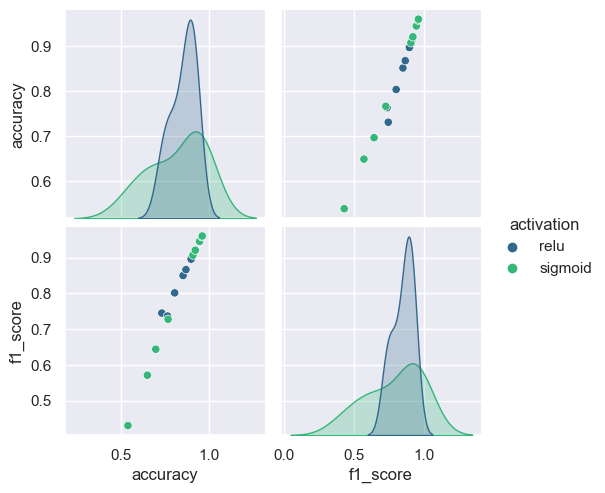

In [17]:
# Let's see the pairplot for the Neural Network results
sns.pairplot(results_nn, hue='activation', palette='viridis')

### Basic Neural Network Implementation optimized to run on GPU

## [x] Question 5.
When executing multiple times (using ReLU or sigmoid activations) for a fixed number of iterations, how much does the validation accuracy vary at the end of the training? What is causing the variation in performance?


If we look at the training history of the above models, we can see that the validation accuracy varies constantly increases for both of the activation functions. However, the rate of increase for ReLU is actually higher most of the time. As mentioned above, ReLU is able to help the model converge faster. One downside of ReLU is that when the model is allowed to train for too long with a high learning rate, the validation accuracy starts to fluctuate. This is probably due to the fact that the model starts to overfit the training data or that the learning rate is too high and the model starts to diverge. In such a situation, the model would benefit from an EarlyStopping mechanism.

## [x] Question 6. 
Does the choice of activation function (ReLU vs. sigmoid) make any difference in validation accuracy?

The differences between the two activation functions have already been outlined in the above section.

> From the above, we can see that the top 3 performing models all have the Sigmoid activation function. However, if we pay attention to the training history, we can see that the ReLU activation function has a much faster convergence rate. This is probably due to the fact that the ReLU function is less computationally expensive than the Sigmoid function an can also deal with the vanishing gradient problem. 

**Evidence suggests that the choice of activation function does make a difference in validation accuracy. However, it is important to note that many overfitting prevention techniques were not implemented in this model. Thus, it is possible that with the right hyperparameters, the ReLU activation function can achieve similar or better results than the Sigmoid activation function at a much faster rate.**

In [18]:
#@title Basic Neural Network Algorithm

class GPUDeepNeuralNetworkLearningAlgorithm(BaseLearningAlgorithm):
    def __init__(self, sizes, epochs=10, l_rate=0.001, activation='sigmoid'):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate
        self.activation = activation
        # Save all parameters in the neural network in this dictionary
        self.params = self.initialization()
        
        # check if GPU is available
        self.device = 'GPU' if tf.test.is_gpu_available() else 'CPU'

        self.activation_function = self.get_activation_function(activation)

    def get_activation_function(self, name):
        if name == 'sigmoid':
            return self.sigmoid
        elif name == 'relu':
            return self.relu
        # You can add more activation functions as needed
        else:
            raise ValueError(f"Activation function {name} not supported.")

    # def sigmoid(self, x, derivative=False):
    #     if derivative:
    #         return (tf.exp(-x))/((tf.exp(-x)+1)**2)
    #     return 1/(1 + tf.exp(-x))

    # def relu(self, x, derivative=False):
    #   if derivative:
    #     return 1. * (x > 0)     
      
    #   return tf.maximum(0, x)

    def sigmoid(self, x):
        return 1 / (1 + tf.exp(-x))

    def relu(self, x):
        return tf.maximum(0, x)

    def softmax(self, x, derivative=False):
        exps = tf.exp(x - x.max())
        if derivative:
            return exps / tf.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / tf.sum(exps, axis=0)

    def initialization(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            'W1': tf.Variable(tf.random.normal([hidden_1, input_layer]) * tf.sqrt(1. / hidden_1)),
            'W2': tf.Variable(tf.random.normal([hidden_2, hidden_1]) * tf.sqrt(1. / hidden_2)),
            'W3': tf.Variable(tf.random.normal([output_layer, hidden_2]) * tf.sqrt(1. / output_layer))
        }

        return params

    def forward_pass(self, x_train: tf.Tensor) -> np.array:
        # print("Computing Forward Pass")
        params = self.params

        # input layer activations becomes sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        params['Z1'] = tf.tensordot(params["W1"], params['A0'], axes=1)
        # print("Layer params computed")
        params['A1'] = self.activation_function(params['Z1'])

        # hidden layer 1 to hidden layer 2
        params['Z2'] = tf.tensordot(params["W2"], params['A1'], axes=1)
        # print("Layer params computed")
        params['A2'] = self.activation_function(params['Z2'])

        # hidden layer 2 to output layer
        params['Z3'] = tf.tensordot(params["W3"], params['A2'], axes=1)
        # Use softmax for the output layer, or you can change this as per your needs.
        # print("Layer params computed")
        params['A3'] = tf.nn.softmax(params['Z3']) 

        return params['A3']

    def backward_pass_and_update(self, x: tf.Tensor, y_true: tf.Tensor) -> None:
        """Perfoms backpropagation. using tf.GradientTape"""
        
        with tf.GradientTape(persistent=True) as tape:
            # print("Tape initiated")
            # Watch the input tensor
            tape.watch(x)
            # print("Inpuit tensor is being watched")

            # Forward pass
            logits = self.forward_pass(x)
            # print("Logits computed")
            # print(f"Logits shape; {logits.shape}")
            
            # Compute loss
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_true, logits))
            # print("loss computed")

        # Get gradients
        dw3, dw2, dw1 = tape.gradient(loss, [self.params['W3'], self.params['W2'], self.params['W1']])
        
        # Update weights
        self.params['W3'].assign_sub(self.l_rate * dw3)
        self.params['W2'].assign_sub(self.l_rate * dw2)
        self.params['W1'].assign_sub(self.l_rate * dw1)

        del tape

    def compute_accuracy(self, x_val, y_val):
        """
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output equals the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        """
        predictions = []
        y_val = to_categorical(y_val)
        for x, y in zip(x_val, y_val):

            output = self.forward_pass(x)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))

        return np.mean(predictions)

    def predict(self, X_test: np.array) -> np.array:
      """Predicts on a test set."""
      return np.array([str(np.argmax(self.forward_pass(x))) for x in X_test])

    def fit(self, x_train, y_train, x_val, y_val):
        y_train = to_categorical(y_train)
        # print("Starting to fit")
        # Convert all numpy arrays to tensors
        x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
        y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
        x_val = tf.convert_to_tensor(x_val, dtype=tf.float32)
        y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)
        # print(x_train.shape, y_train.shape)
        # print("Converted all np arrays to tensors")
        
        with tf.device(self.device):
            print(f'>>> Training on {self.device} <<<')        
            start_time = time.time()
            for iteration in range(self.epochs):
                # print("Iteration no", iteration)
                for x,y in zip(x_train, y_train):
                    # print(x_train.shape, y_train.shape)

                    self.backward_pass_and_update(x, y)

                accuracy = self.compute_accuracy(x_val, y_val)
                print('Epoch: {0}, Time Spent: {1:.2f}s, Validation Accuracy: {2:.2f}%'.format(
                    iteration+1, time.time() - start_time, accuracy * 100
                ))
                
    @property
    def name(self) -> str:
      return 'Basic Neural Network'

## 4.2 Feedforward Neural Network with Keras and Tensorflow (Task 6)
Next, set up and train a feedforward neural network in [Keras](https://keras.io/) and [Tensorflow](https://www.tensorflow.org/).



1.   Paramaterize your model with the number of hidden layers, epochs, learning rate, and activation function.
2.   Add **early stopping** and add a patience parameter. You can apply the [keras callback function](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) to implement early stopping.
3.   Apply sparse categorical entropy loss function.
4.   Apply Adaptive Moments (Adam) optimizer






In [27]:
class KerasDnnLearningAlgorithm(BaseLearningAlgorithm):
    """Feed Forward Neural Network Classifier function."""

    def __init__(
        self,
        hidden_layers: List[int],
        epochs: int,
        learning_rate: float,
        activation: str,
        es_patience: int = 5,
        use_gpu: bool = True,
        dropout_layers: Union[List[float], None] = None,
    ):
        """Initializes the model."""
        self.hidden_layers = hidden_layers
        self.epochs = epochs
        self.learning_rate = learning_rate
        
        # Check if the dropout layers are provided and compatible with the hidden layers
        if dropout_layers is not None:
            if len(dropout_layers) != len(hidden_layers):
                raise ValueError(
                    f"Number of dropout layers {len(dropout_layers)} does not match number of hidden layers {len(hidden_layers)}"
                )
            self.dropout_layers = dropout_layers
        else:
            self.dropout_layers = [None] * len(hidden_layers)
        
        # Check if the activation is supported
        supported_activations = ["relu", "sigmoid"]
        if activation not in supported_activations:
            raise ValueError(
                f"Activation {activation} not supported. Supported activations are {supported_activations}"
            )
        self.activation = activation
        self.es_patience = es_patience

        self.model = tf.keras.models.Sequential()
        self.model.add(tf.keras.layers.InputLayer(input_shape=(784,)))
        for i, (hidden_size, dropout_rate) in enumerate(zip(self.hidden_layers, self.dropout_layers)):
                    
            self.model.add(
                tf.keras.layers.Dense(
                    hidden_size, activation=self.activation, name=f"hidden_layer_{i}"
                ),
            )
            
            if dropout_rate is not None:
                self.model.add(tf.keras.layers.Dropout(dropout_rate, name=f"dropout_{i}"))
            
        self.model.add(tf.keras.layers.Dense(10, activation="softmax"))
        
        # Check if GPU is available
        if use_gpu:
            physical_devices = tf.config.list_physical_devices("GPU")
            # Set the device to GPU if available else CPU
            if len(physical_devices) > 0:
                # Make sure to only use as much GPU memory as needed
                # tf.config.experimental.set_memory_growth(physical_devices[0], True)
                self.device = "/GPU:0"
                print(">>> Running on GPU")
            else:
                self.device = "/CPU:0"
                print(">>> Running on CPU!")
        
        # Compile the model with Nadam optimizer and Early Stopping on selected device
        with tf.device(self.device):
            self.model.compile(
                optimizer=tf.keras.optimizers.Nadam(learning_rate=self.learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics=["sparse_categorical_crossentropy"],
            )

    def fit(
        self, x_train: np.array, y_train: np.array, x_val: np.array, y_val: np.array
    ) -> None:
        """Trains a model from labels y and examples X.

        Args:
            x_train (np.array): the training input data
            y_train (np.array): the training output data
            x_val (np.array): the validation input data
            y_val (np.array): the validation output data
        Returns:
            None
        """
        print(y_train.shape)
        print(y_train.unique())
        y_train = y_train.astype(int)
        y_val = y_val.astype(int)
        
        # y_train = to_categorical(y_train).reshape(-1, y_train.nunique())
        # y_val = to_categorical(y_val).reshape(-1, y_val.nunique())
        print(y_train.shape)
        
        self.model.fit(
            x_train,
            y_train,
            epochs=self.epochs,
            validation_data=(x_val, y_val),
            callbacks=[
                EarlyStopping(
                    patience=self.es_patience,
                    restore_best_weights=True,
                    min_delta=0.001,
                    monitor="val_loss",
                )
            ],
        )

    def predict(self, x_test: np.array) -> np.array:
        """Predicts on an unlabeled sample, X.

        Args:
            x_test (np.array): the test input data

        Returns:
            np.array: the predicted output data
        """
        y_pred = self.model.predict(x_test)
        y_pred = np.argmax(y_pred, axis=1).astype('str')
        return y_pred

    @property
    def name(self) -> str:
        return "Feed Forward Neural Network using Keras and Tensorflow"

In [55]:
learning_algo = KerasDnnLearningAlgorithm(hidden_layers=[128, 64], epochs=1000, learning_rate=0.001, activation = 'relu')
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)

(56700,)
['1', '4', '2', '8', '3', '5', '0', '6', '7', '9']
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']
(56700, 10)
Epoch 1/1000


InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\togru\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\togru\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1053, in launch_instance

  File "C:\Users\togru\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 736, in start

  File "C:\Users\togru\AppData\Roaming\Python\Python311\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "c:\Users\togru\anaconda3\envs\gen-ml\Lib\asyncio\base_events.py", line 607, in run_forever

  File "c:\Users\togru\anaconda3\envs\gen-ml\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "c:\Users\togru\anaconda3\envs\gen-ml\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\togru\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue

  File "C:\Users\togru\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 505, in process_one

  File "C:\Users\togru\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell

  File "C:\Users\togru\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 740, in execute_request

  File "C:\Users\togru\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "C:\Users\togru\AppData\Roaming\Python\Python311\site-packages\ipykernel\zmqshell.py", line 546, in run_cell

  File "C:\Users\togru\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "C:\Users\togru\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "C:\Users\togru\AppData\Roaming\Python\Python311\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\togru\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "C:\Users\togru\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "C:\Users\togru\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\togru\AppData\Local\Temp\ipykernel_4820\3550981386.py", line 2, in <module>

  File "C:\Users\togru\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 2432, in run_line_magic

  File "C:\Users\togru\AppData\Roaming\Python\Python311\site-packages\IPython\core\magics\execution.py", line 1332, in time

  File "<timed eval>", line 1, in <module>

  File "C:\Users\togru\AppData\Local\Temp\ipykernel_4820\2102725092.py", line 6, in train_eval

  File "C:\Users\togru\AppData\Local\Temp\ipykernel_4820\4021925907.py", line 63, in fit

  File "c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\keras\src\engine\training.py", line 1783, in fit

  File "c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\keras\src\engine\training.py", line 1377, in train_function

  File "c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\keras\src\engine\training.py", line 1360, in step_function

  File "c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\keras\src\engine\training.py", line 1349, in run_step

  File "c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\keras\src\engine\training.py", line 1127, in train_step

  File "c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\keras\src\engine\training.py", line 1185, in compute_loss

  File "c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__

  File "c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\keras\src\losses.py", line 143, in __call__

  File "c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\keras\src\losses.py", line 270, in call

  File "c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\keras\src\losses.py", line 2454, in sparse_categorical_crossentropy

  File "c:\Users\togru\anaconda3\envs\gen-ml\Lib\site-packages\keras\src\backend.py", line 5777, in sparse_categorical_crossentropy

logits and labels must have the same first dimension, got logits shape [32,10] and labels shape [320]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_17648]

In [28]:
# let's try this model with some dropout layers as well
nn_keras_dropout = KerasDnnLearningAlgorithm(
    hidden_layers=[128, 64],
    epochs=1000,
    learning_rate=0.001,
    activation="relu",
    dropout_layers=[0.2, 0.2],
)

# train and evaluate the model
%time train_eval(nn_keras_dropout, x_train, y_train, x_val, y_val, x_test, y_test)

ValueError: not enough values to unpack (expected 3, got 2)

## Question 6
Summarize the results of all your classifiers. Which classifiers performed better or worse than the logistic regression benchmark? Which method executed fastest in terms of time? Which was easiest to set up and parameterize? Which classes tended to get most often confused across all classifiers?

# Optional Extra Credit (max course credit: 3%)


*   Implement early stopping in 4.1 (**1% extra credit**).
*   Add in one or more Keras dropout layers in 4.2 (**1% extra credit**).
*   Implement mini-batch gradient descent in 4.1, replacing stochastic gradient descent. Instead of making an update to a parameter for each sample, make an update based on the averaged value of each sample in a mini-batch. The size of the mini-batch is usually below 64. (**3% extra credit**)
*  Initialize biases and add them to Z in 4.1 before the activation function in the forward pass, and update the biases in the backward pass.  (**2% extra credit**)


